# Projet 7 - Implémentez un modèle de scoring 

## Table des matières

* [Introduction](#Introduction)
* [1. Chargement de l'environnement virtuel de Jupyter](#section_1)
* [2. Chargement du dataset de la société financière "Prêt à dépenser"](#section_2)
* [3. Exploration des données](#section_3)
* [Conclusion](#Conclusion)

# Introduction <a class="anchor" id="Introduction"></a>

## 1. Chargement de l'environnement virtuel de Jupyter 
<a class="anchor" id="section_1"></a>

In [1]:
import sys
print(sys.executable)

C:\Users\robin\anaconda3\python.exe


In [2]:
# 1.1 Importing packages for data exploration and visualisation
import ast
import collections
import math
import os
import re
import sys
import warnings
from datetime import datetime
from math import asin, cos, radians, sin, sqrt
from time import time

import black
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection
from matplotlib.ticker import PercentFormatter
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from kmodes.kprototypes import KPrototypes
import sklearn
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.neighbors import LocalOutlierFactor
from collections import defaultdict
from scipy import stats
from scipy.stats import norm
from scipy.stats import multivariate_normal as mn
from scipy.stats import zscore
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from collections import defaultdict
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image
import pickle
import time
import logging

from IPython.display import HTML, display
logging.disable(logging.WARNING) 

import gensim

import tensorflow as tf
import tensorflow.keras
import tensorflow.python
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub

import os
import transformers
from transformers import AutoModel

import opendatasets as od


In [3]:
# 1.2. Checking package versions
print("Python Version: " + sys.version)
print("Matplotlib Version: " + mpl.__version__)
print("NumPy Version: " + np.version.full_version)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Scikit-learn Version: " + sklearn.__version__)
print("Tensorflow Version: " + tf.__version__)

Python Version: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Matplotlib Version: 3.5.1
NumPy Version: 1.21.5
Pandas Version: 1.4.3
Seaborn Version: 0.11.2
Scikit-learn Version: 1.1.1
Tensorflow Version: 2.9.1


In [4]:
from zipfile import ZipFile
file_name = 'Projet+Mise+en+prod+-+home-credit-default-risk.zip' 
with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Done')

Done


## 2. Chargement du dataset de la société financière "Prêt à dépenser"
<a class="anchor" id="section_2"></a>

**Fichier "application_{train|test}.csv"**
* Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
* Ici, une ligne représente un prêt pour un individu dans notre échantillon de données.

In [5]:
# Reading of datasets 
application_train_df = pd.read_csv("application_train.csv", encoding = 'utf-8')
print('Application_train shape :', application_train_df.shape)
application_train_df.head()

Application_train shape : (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
application_test_df = pd.read_csv("application_test.csv", encoding = 'utf-8')
print('Application_test shape :', application_test_df.shape)
application_test_df.head()

Application_test shape : (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


**Fichier "bureau_balance.csv"**
* Soldes mensuels des crédits précédents dans le Bureau de Crédits.
* Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent rapporté au Bureau de Crédits.

In [7]:
bureau_balance_df = pd.read_csv("bureau_balance.csv", encoding = 'utf-8')
print('Bureau_balance shape :', bureau_balance_df.shape)
bureau_balance_df.head()

Bureau_balance shape : (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


**Fichier "POS_CASH_balance.csv"**
* Instantanés des soldes mensuels des prêts POS (point of sales) et cash précédents que le demandeur a eu avec un Home Credit.
* Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit antérieur au Home Credit (crédit à la consommation et prêts de caisse) lié aux prêts de notre échantillon.

In [8]:
pos_cash_balance_df = pd.read_csv("pos_cash_balance.csv", encoding = 'utf-8')
print('POS_CASH_balance shape :', pos_cash_balance_df.shape)
pos_cash_balance_df.head()

POS_CASH_balance shape : (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


**Fichier "previous_application.csv"**
* Toutes les demandes précédentes de prêts pour le crédit immobilier des clients qui ont des prêts dans notre échantillon.
* Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données.

In [9]:
previous_application_df = pd.read_csv("previous_application.csv", encoding = 'utf-8')
print('Previous_application shape :', previous_application_df.shape)
previous_application_df.head()

Previous_application shape : (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


**Fichier "credit_card_balance.csv"**
* Instantanés des soldes mensuels des cartes de crédit précédentes que le demandeur possède chez Home Credit.
* Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans le Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts dans notre échantillon.

In [10]:
credit_card_balance_df = pd.read_csv("credit_card_balance.csv", encoding = 'utf-8')
print('Credit_card_balance shape :', credit_card_balance_df.shape)
credit_card_balance_df.head()

Credit_card_balance shape : (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


**Fichier "installments_payments.csv"**
* Historique des remboursements pour les crédits précédemment déboursés dans Home Credit liés aux prêts de notre échantillon.
* Il y a a) une ligne pour chaque paiement effectué et b) une ligne pour chaque paiement manqué.
* Une ligne est équivalente à un paiement d'un versement OU à un versement correspondant à un paiement d'un crédit Home Credit précédent lié aux prêts de notre échantillon.

In [11]:
installments_payments_df = pd.read_csv("installments_payments.csv", encoding = 'utf-8')
print('Installments_payments shape :', installments_payments_df.shape)
installments_payments_df.head()

Installments_payments shape : (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


**Fichier "bureau.csv"**
* Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été rapportés au Bureau de Crédits (pour les clients qui ont un prêt dans notre échantillon).
* Pour chaque prêt de notre échantillon, il y a autant de lignes que de crédits que le client avait dans le Credit Bureau avant la date de la demande.

In [12]:
bureau_df = pd.read_csv("bureau.csv", encoding = 'utf-8')
print('Bureau shape :', bureau_df.shape)
bureau_df.head()

Bureau shape : (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [13]:
# Exploration of the general information in the various data files 
files_names = ['application_train', 'application_test', 'bureau_balance', 'pos_cash_balance', 'previous_application',
        'credit_card_balance', 'installments_payments', 'bureau']

files = [application_train_df, application_test_df, bureau_balance_df, pos_cash_balance_df, previous_application_df,
        credit_card_balance_df, installments_payments_df, bureau_df]

In [14]:
for i in range(len(files)):
    print('{}: \n'.format(files_names[i]))
    print('Shape is: ',files[i].shape,'\n')
    print(files[i].info())
    print('\n\n*****************************************\n\n')

application_train: 

Shape is:  (307511, 122) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


*****************************************


application_test: 

Shape is:  (48744, 121) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


*****************************************


bureau_balance: 

Shape is:  (27299925, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB
None


*********************************

In [15]:
# Checking the structure of the main dataset
print('Training Features shape: ', application_train_df.shape)
print('Testing Features shape: ', application_test_df.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


In [16]:
# Checking if 'TARGET' is the only difference 
display(application_train_df.columns.difference(application_test_df.columns))
print("Check theses two files for Train (with TARGET) and Test (without TARGET).")

Index(['TARGET'], dtype='object')

Check theses two files for Train (with TARGET) and Test (without TARGET).


In [17]:
# Distribution of the Target Column
application_train_df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

### Exploration des données 

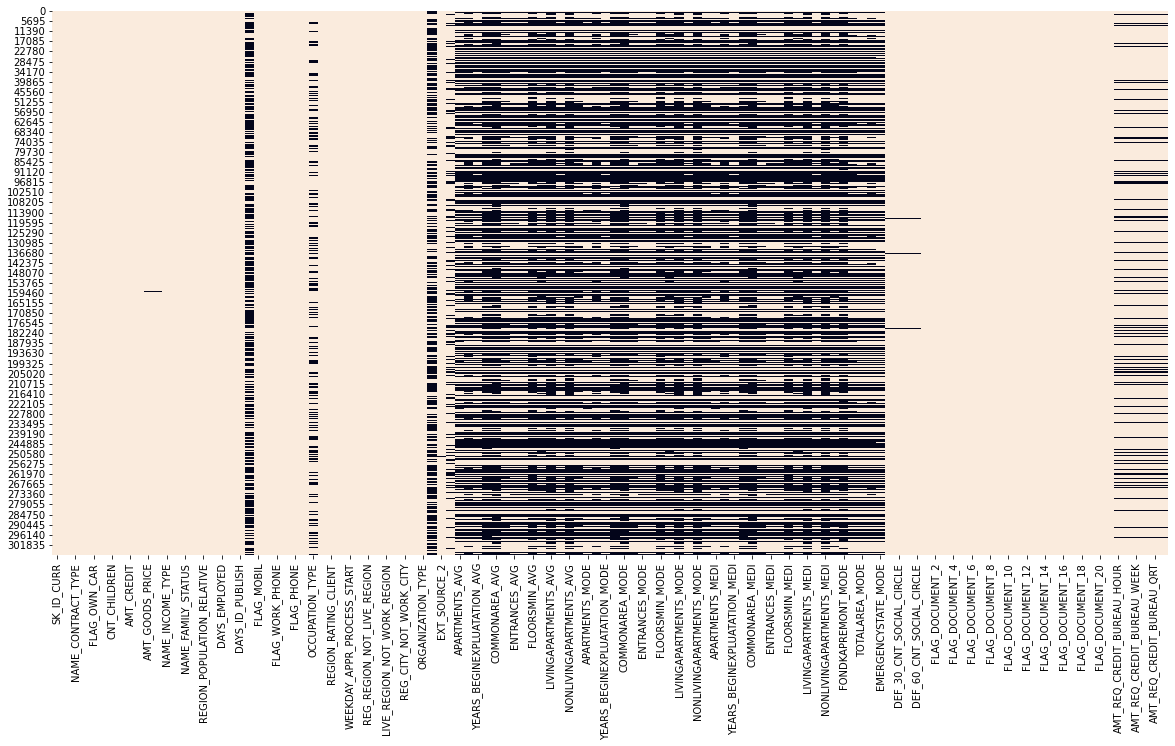

In [18]:
# Global view of the missing values (in black color)
plt.figure(figsize=(20,10))
sns.heatmap(application_train_df.notna(), cbar=False)
plt.show()

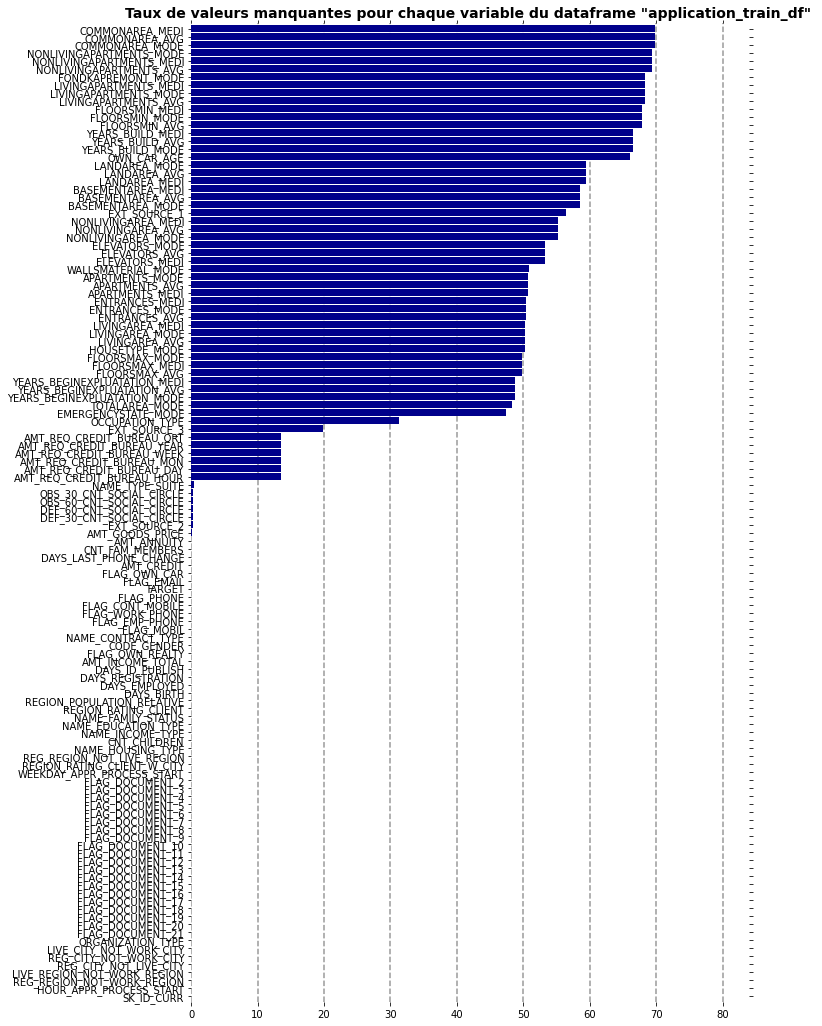

In [19]:
# For each variable, we look at the percentage of missing data
size = application_train_df.shape
nan_values = application_train_df.isna().sum()

nan_values = nan_values.sort_values(ascending=True) * 100 / size[0]

ax = nan_values.plot(
    kind="barh", figsize=(10, 18), color="darkblue", zorder=2, width=0.85
)

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.tick_params(
    axis="both",
    which="both",
    bottom="off",
    top="off",
    labelbottom="on",
    left="off",
    right="off",
    labelleft="on",
)
ax.set_title(
    'Taux de valeurs manquantes pour chaque variable du dataframe "application_train_df" ',
    fontsize=14,
    fontweight="bold",
)
vals = ax.get_xticks()

for tick in vals:
    ax.axvline(x=tick, linestyle="dashed", alpha=0.4, color="black", zorder=1)

In [20]:
def nan_check(data):
    '''Check Missing Values'''
    total = data.isnull().sum()
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 2))
    missing_data = pd.concat([total, percent_2], 
                             axis=1, keys=['Total', '%']).sort_values('%', ascending=False)
    return missing_data

print('TOP 10 Missing values from Training dataset')
nan_check(application_train_df)[:10]

TOP 10 Missing values from Training dataset


,Total,%
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35


In [21]:
print("Nb of columns in the training sample: " + str(len(nan_check(application_train_df))))

print("Nb of columns in the training sample with missing values: " + 
      str(len(nan_check(application_train_df)[nan_check(application_train_df)['Total']!=0])))

Nb of columns in the training sample: 122
Nb of columns in the training sample with missing values: 67


In [22]:
application_train_df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [23]:
application_train_df.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

### Nettoyage de données 

In [24]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [25]:
# Check of the new dataset structure 
application_train_test_df = application_train_test()

Train samples: 307511, test samples: 48744


In [26]:
application_train_test_df.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623


In [27]:
bureau_balance_df = bureau_and_balance()

In [28]:
bureau_balance_df.head()

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.0,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.0,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.0,13.0


In [29]:
pos_cash_balance_df = pos_cash()

In [30]:
credit_card_balance_df = credit_card_balance()

In [31]:
previous_application_df_cleaned = previous_applications()

In [32]:
installments_payments_df = installments_payments()

In [33]:
application_train_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Columns: 248 entries, index to PAYMENT_RATE
dtypes: float64(72), int64(43), uint8(133)
memory usage: 360.5 MB


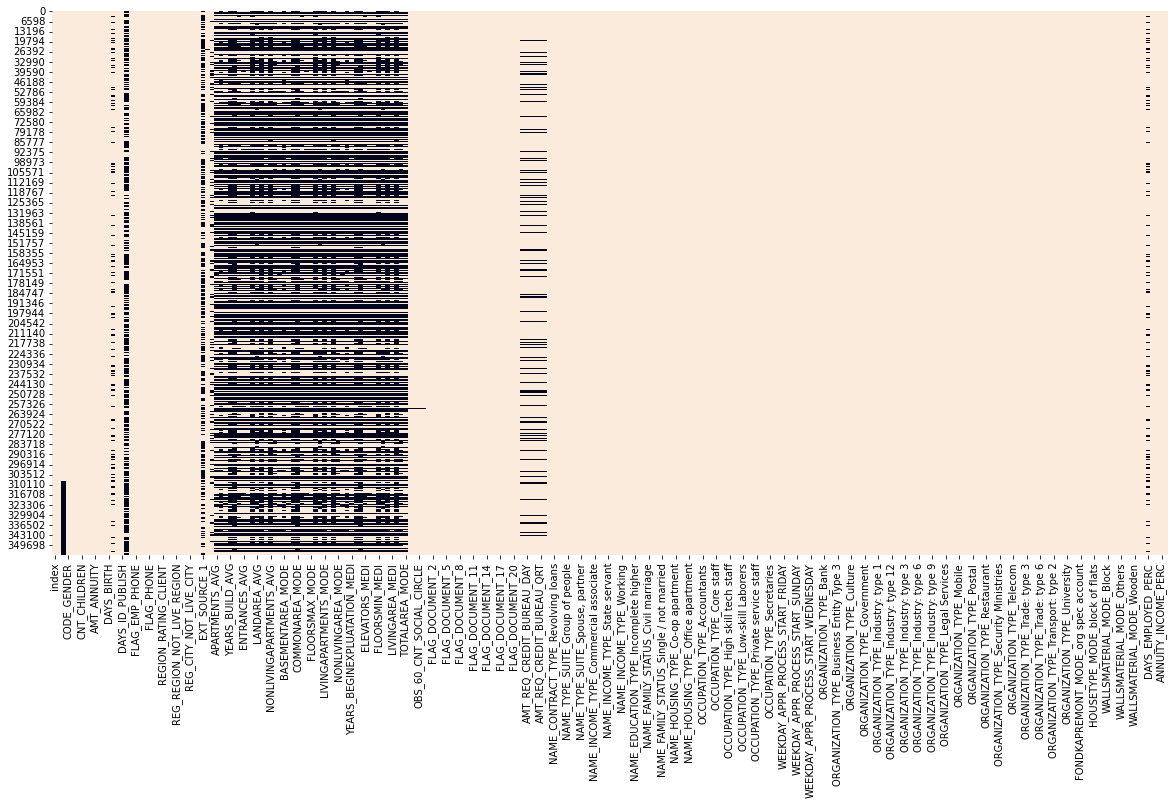

In [34]:
# Global view of the missing values (in black color)
plt.figure(figsize=(20,10))
sns.heatmap(application_train_test_df.notna(), cbar=False)
plt.show()

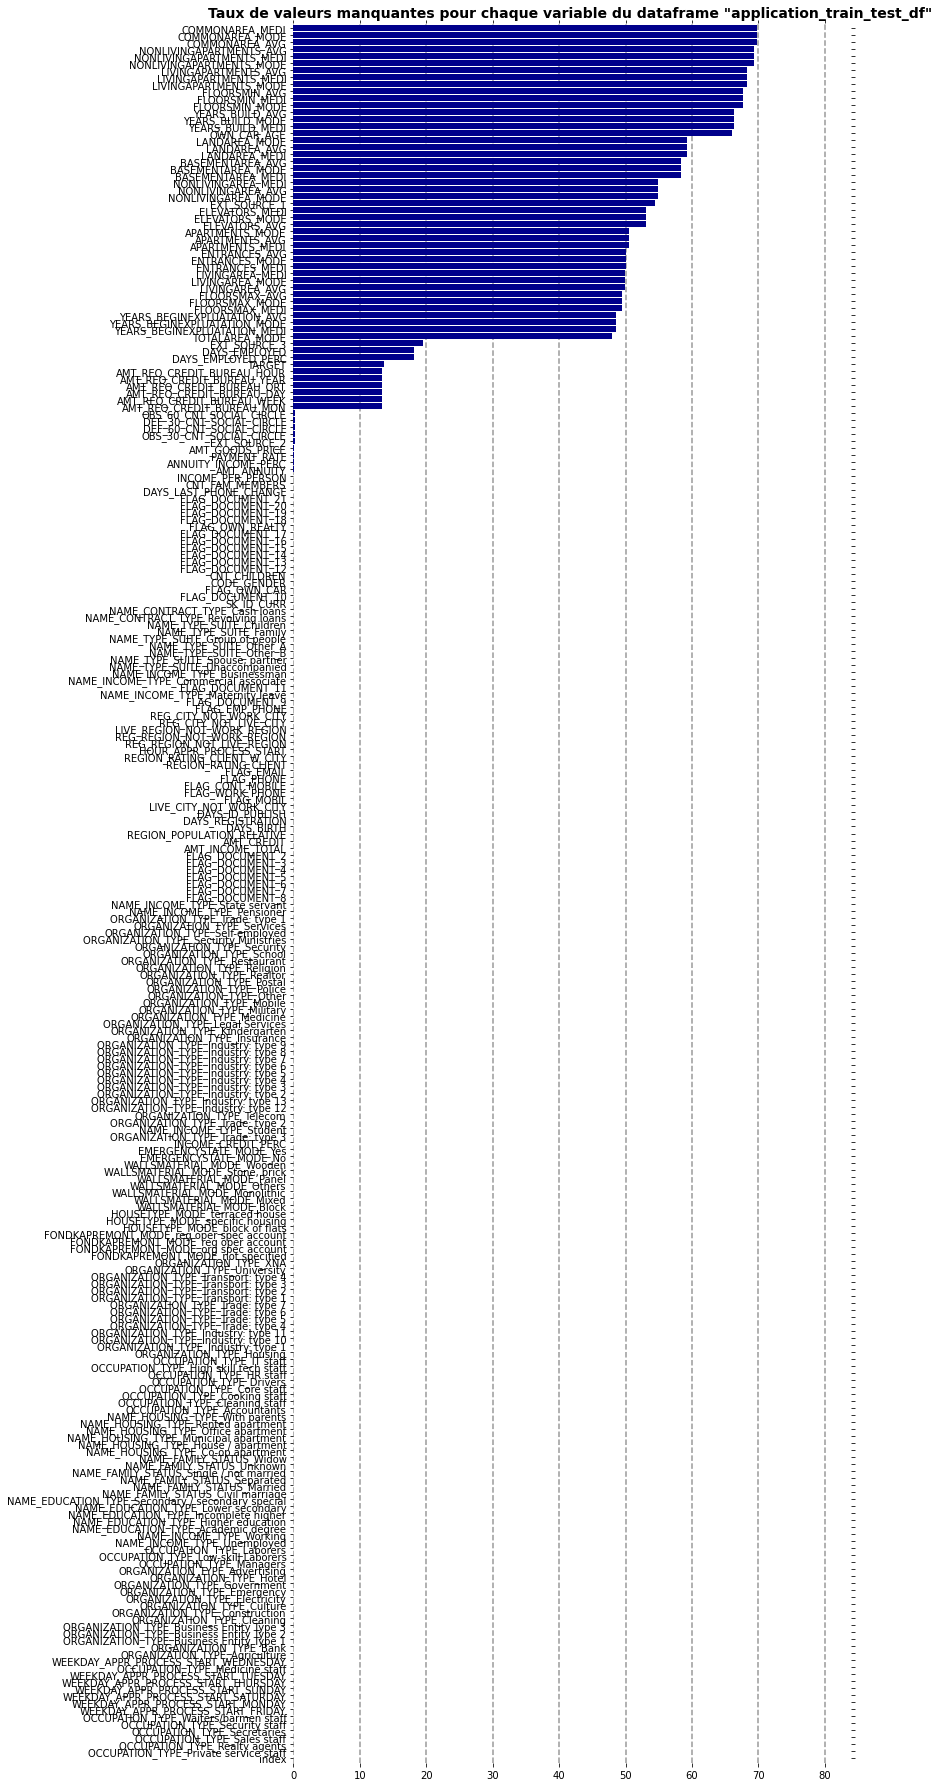

In [35]:
# For each variable, we look at the percentage of missing data

size = application_train_test_df.shape
nan_values = application_train_test_df.isna().sum()

nan_values = nan_values.sort_values(ascending=True) * 100 / size[0]

ax = nan_values.plot(
    kind="barh", figsize=(10, 32), color="darkblue", zorder=2, width=0.85
)

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.tick_params(
    axis="both",
    which="both",
    bottom="off",
    top="off",
    labelbottom="on",
    left="off",
    right="off",
    labelleft="on",
)
ax.set_title(
    'Taux de valeurs manquantes pour chaque variable du dataframe "application_train_test_df" ',
    fontsize=14,
    fontweight="bold",
)
vals = ax.get_xticks()

for tick in vals:
    ax.axvline(x=tick, linestyle="dashed", alpha=0.4, color="black", zorder=1)

In [36]:
nan_check(application_train_test_df)[:30]

,Total,%
COMMONAREA_AVG,248357,69.71
COMMONAREA_MODE,248357,69.71
COMMONAREA_MEDI,248357,69.71
NONLIVINGAPARTMENTS_AVG,246859,69.29
NONLIVINGAPARTMENTS_MEDI,246859,69.29
NONLIVINGAPARTMENTS_MODE,246859,69.29
LIVINGAPARTMENTS_MEDI,242977,68.20
LIVINGAPARTMENTS_AVG,242977,68.20
LIVINGAPARTMENTS_MODE,242977,68.20
FLOORSMIN_AVG,241106,67.68


In [37]:
print("Nb of columns in the training sample: " + str(len(nan_check(application_train_test_df))))

print("Nb of columns in the training sample with missing values: " + 
      str(len(nan_check(application_train_test_df)[nan_check(application_train_test_df)['Total']!=0])))

Nb of columns in the training sample: 248
Nb of columns in the training sample with missing values: 67


In [38]:
# Observation of duplicated data
application_train_test_df.duplicated(keep=False).sum()

0

In [39]:
# Calculating the percentage of duplicates
duplicates_percentage_notcleaned = (
    application_train_test_df.duplicated(keep=False).value_counts(normalize=True) * 100
)
print(duplicates_percentage_notcleaned)

False    100.0
dtype: float64


In [40]:
application_train_test_df.describe()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
count,356251.000000,356251.000000,307507.00000,356251.000000,356251.000000,356251.000000,356251.000000,3.562510e+05,3.562510e+05,356215.000000,...,356251.000000,356251.000000,356251.000000,356251.000000,356251.000000,291603.000000,356251.000000,3.562490e+05,356215.000000,356215.000000
mean,136052.869904,278128.870078,0.08073,0.660001,0.339699,0.306764,0.414312,1.701159e+05,5.877695e+05,27425.644390,...,0.217004,0.211219,0.017280,0.520992,0.007534,0.157797,0.411925,9.378647e+04,0.181212,0.055463
std,93841.582375,102842.068890,0.27242,0.473709,0.473608,0.461151,0.720376,2.235080e+05,3.986253e+05,14732.860946,...,0.412206,0.408174,0.130313,0.499560,0.086471,0.133449,0.496408,9.810132e+04,0.094701,0.023206
min,0.000000,100001.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.011801,2.812500e+03,0.000224,0.022073
25%,44532.000000,189065.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.056954,0.200000,4.950000e+04,0.114950,0.038080
50%,129384.000000,278129.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.120073,0.316570,7.500000e+04,0.163182,0.050000
75%,218447.500000,367192.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.220597,0.500000,1.125000e+05,0.229156,0.067066
max,307510.000000,456255.000000,1.00000,1.000000,1.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.728811,208.003328,3.900000e+07,2.024714,0.124430


In [41]:
# We look at the single categorical variables in each dataframe

for column in application_train_test_df.columns:
    if application_train_test_df[column].nunique() < 20:
        print(
            "Colonne {}, valeurs uniques :\n{}\n".format(
                column, application_train_test_df[column].unique()
            )
        )
    else:
        print(
            "Colonne {}, {} valeurs uniques".format(column, application_train_test_df[column].nunique())
        )

Colonne index, 307509 valeurs uniques
Colonne SK_ID_CURR, 356251 valeurs uniques
Colonne TARGET, valeurs uniques :
[ 1.  0. nan]

Colonne CODE_GENDER, valeurs uniques :
[0 1]

Colonne FLAG_OWN_CAR, valeurs uniques :
[0 1]

Colonne FLAG_OWN_REALTY, valeurs uniques :
[0 1]

Colonne CNT_CHILDREN, valeurs uniques :
[ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14 20]

Colonne AMT_INCOME_TOTAL, 2741 valeurs uniques
Colonne AMT_CREDIT, 6480 valeurs uniques
Colonne AMT_ANNUITY, 14166 valeurs uniques
Colonne AMT_GOODS_PRICE, 1291 valeurs uniques
Colonne REGION_POPULATION_RELATIVE, 82 valeurs uniques
Colonne DAYS_BIRTH, 17467 valeurs uniques
Colonne DAYS_EMPLOYED, 12895 valeurs uniques
Colonne DAYS_REGISTRATION, 15898 valeurs uniques
Colonne DAYS_ID_PUBLISH, 6224 valeurs uniques
Colonne OWN_CAR_AGE, 63 valeurs uniques
Colonne FLAG_MOBIL, valeurs uniques :
[1 0]

Colonne FLAG_EMP_PHONE, valeurs uniques :
[1 0]

Colonne FLAG_WORK_PHONE, valeurs uniques :
[0 1]

Colonne FLAG_CONT_MOBILE, valeurs uniq

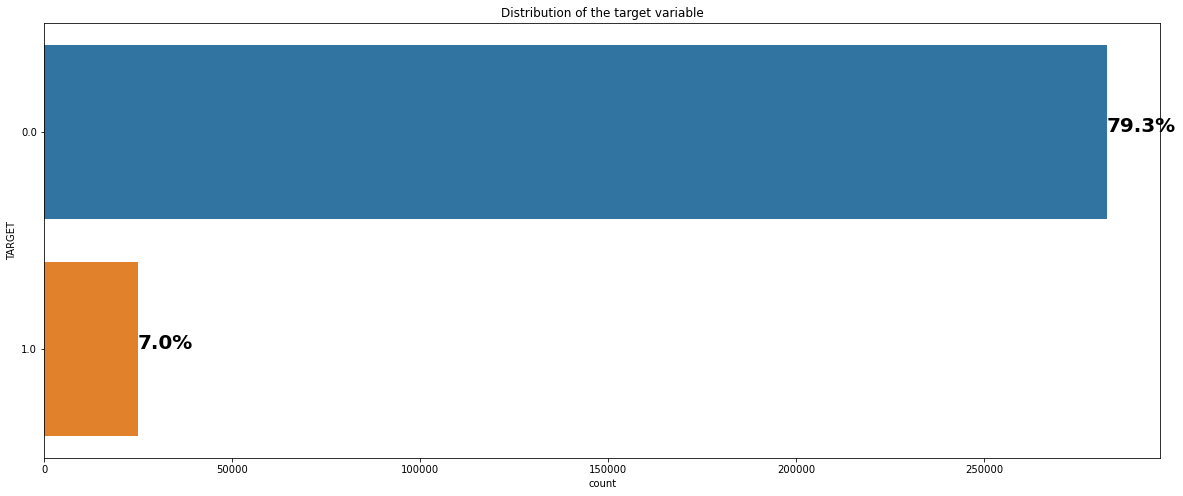

In [42]:
# Distribution of the target variable
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y='TARGET', data=application_train_test_df)
ax.set_title("Distribution of the target variable")

for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(application_train_test_df.TARGET))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')
        
plt.show()

In [43]:
# Number of each type of column
application_train_test_df.dtypes.value_counts()

uint8      133
float64     72
int64       43
dtype: int64

In [44]:
# Number of unique classes in each object column
application_train_test_df.select_dtypes('object').nunique()

Series([], dtype: float64)

### Observation des variables du dataset 

In [45]:
def solvability_clients(df):
    """
    Pieplot de la solvabilité clients
    df(pd.DataFrame): jeu de données
    """
    # % de valeurs 'TARGET' différentes
    target_values = df['TARGET'].value_counts()/len(df)*100
    # Pieplot du % de chaque valeurs différentes de 'TARGET'
    plt.pie(target_values,
            colors=['#2ecc71', '#e74c3c'],
            autopct='%1.1f%%',
            labels=["Solvable", "Non Solvable"],
            startangle=90)
    plt.show()

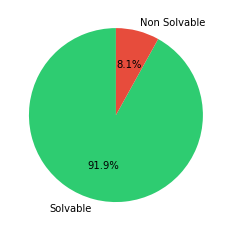

In [46]:
# Pieplot solvabilité clients du jeu d'entrainement
solvability_clients(application_train_test_df)

**Concernant la variable 'TARGET' :**

Le nom de la colonne dont on cherche à prédire la valeur est "TARGET".
La variable prend soit la valeur 0 quand le prêt a été remboursé sans soucis, soit la valeur 1 quand il y a eu un défaut de payement.

Ici, 92 % des prêts ont été remboursés et donc 8 % des individus ont été non solvables.



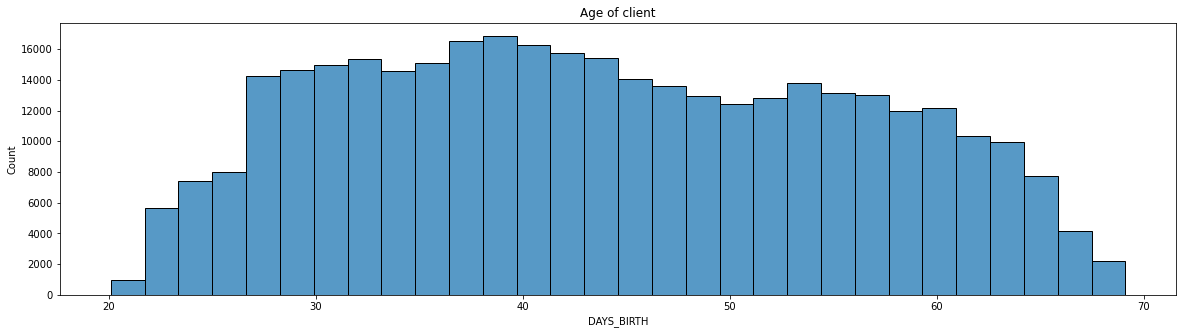

In [47]:
# Distribution of clients' age
plt.figure(figsize=(20, 5))
sns.histplot((application_train_test_df['DAYS_BIRTH'] / -365), bins = 30).set_title('Age of client')
plt.show()

In [48]:
application_train_test_df['DAYS_BIRTH'] 

0         -9461
1        -16765
2        -19046
3        -19005
4        -19932
          ...  
356250   -19970
356251   -11186
356252   -15922
356253   -13968
356254   -13962
Name: DAYS_BIRTH, Length: 356251, dtype: int64

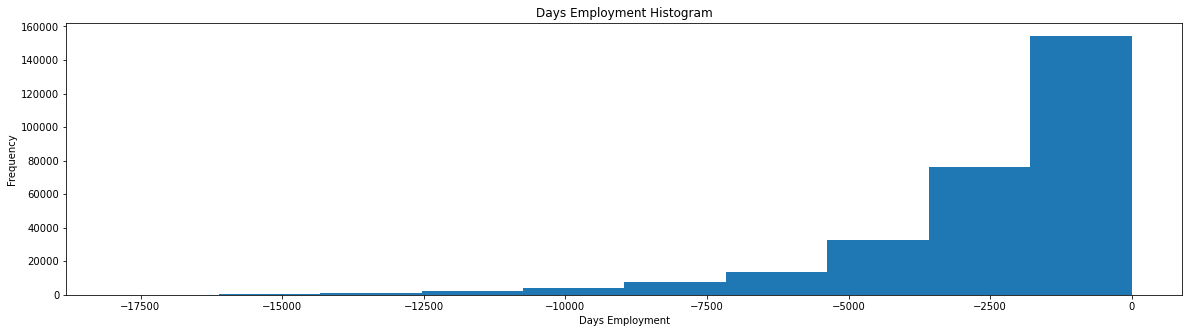

In [49]:
# Histogram of days employment
application_train_test_df['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram', figsize=(20,5));
plt.xlabel('Days Employment')
plt.show()

In [50]:
def plot_stat(data, feature, title) : 
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    plt.show()

In [51]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = application_train_df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_train_df[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

In [52]:
def plot_percent_target1(data, feature, title) : 
    
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Percent of target with value 1")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    plt.show()

In [53]:
def plot_distribution(var):
    
    i = 0
    t1 = application_train_df.loc[application_train_df['TARGET'] != 0]
    t0 = application_train_df.loc[application_train_df['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

In [54]:
import plotly.express as px

**Fichier "application_train_test_df.csv"**

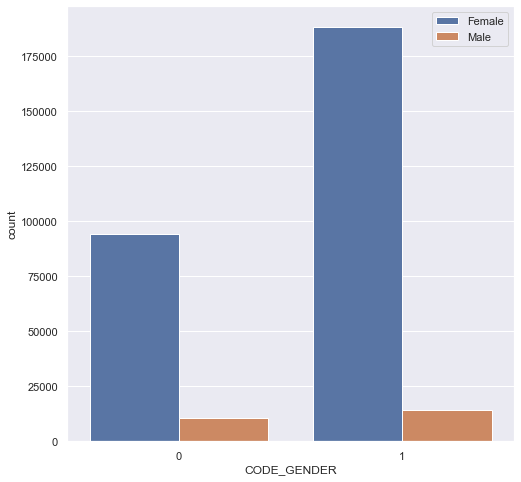

In [55]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style: grey grid in the background:
sns.set(style="darkgrid")

# Set the figure size
plt.figure(figsize=(8, 8))

# Grouped barplot
sns.countplot(x="CODE_GENDER", hue="TARGET", data=application_train_test_df)
plt.legend(labels = ['Female', 'Male'])

**Observations :** Il y a davantage de crédits acceptés pour des individus de sexe féminin par rapport aux individus de type masculin. Cependant, il y a également plus de crédits refusés pour des femmes que pour des hommes, simplement car il y a 14 fois plus de femmes dans notre échantillon que d'hommes. 

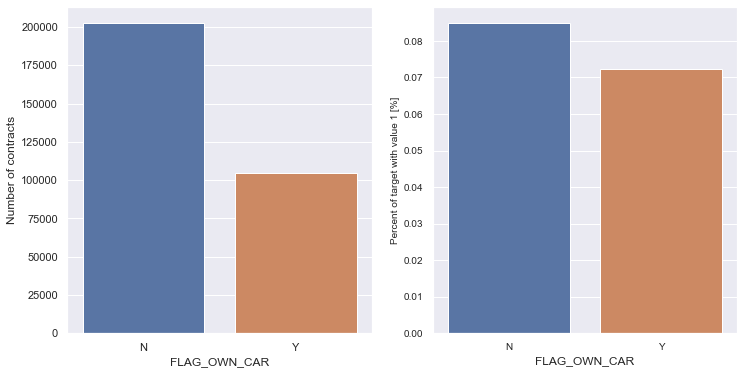

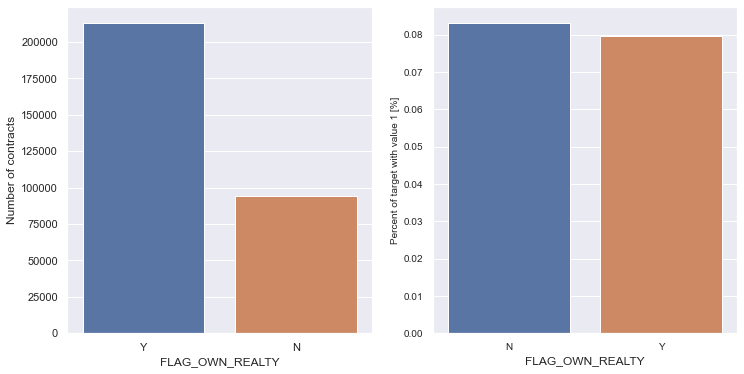

In [56]:
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

**Observations :** Il y a légèrement plus de crédits acceptés lorsque les individus sont propriétaires d'une voiture ou d'un appartement que lorsqu'ils n'y sont pas. 

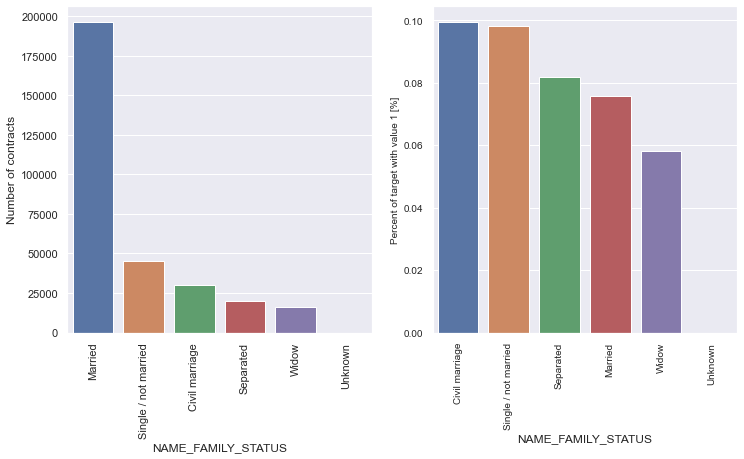

In [57]:
plot_stats('NAME_FAMILY_STATUS',True, True)

**Observations :** Les crédits semblent davantage acceptés pour les couples mariés que pour les personnes seules, mariées civilement ou séparées. 

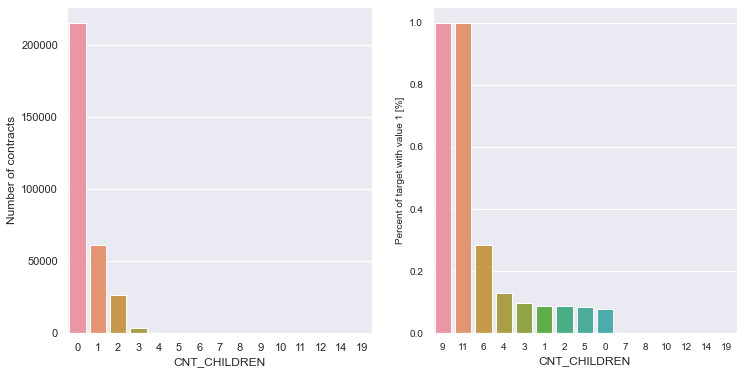

In [58]:
plot_stats('CNT_CHILDREN')

**Observations :** Il y a davantage de crédits acceptés pour les familles n'ayant pas d'enfants à charge par rapport aux familles avec enfants. 

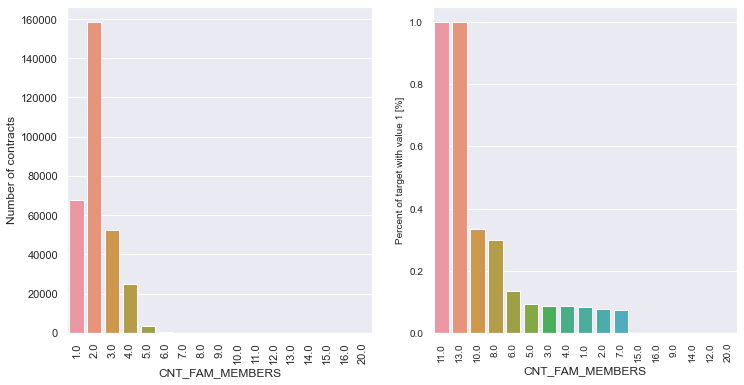

In [59]:
plot_stats('CNT_FAM_MEMBERS',True)

**Observations :** Il y a davantage de crédits acceptés pour les couples que les personnes seules ou les familles. 

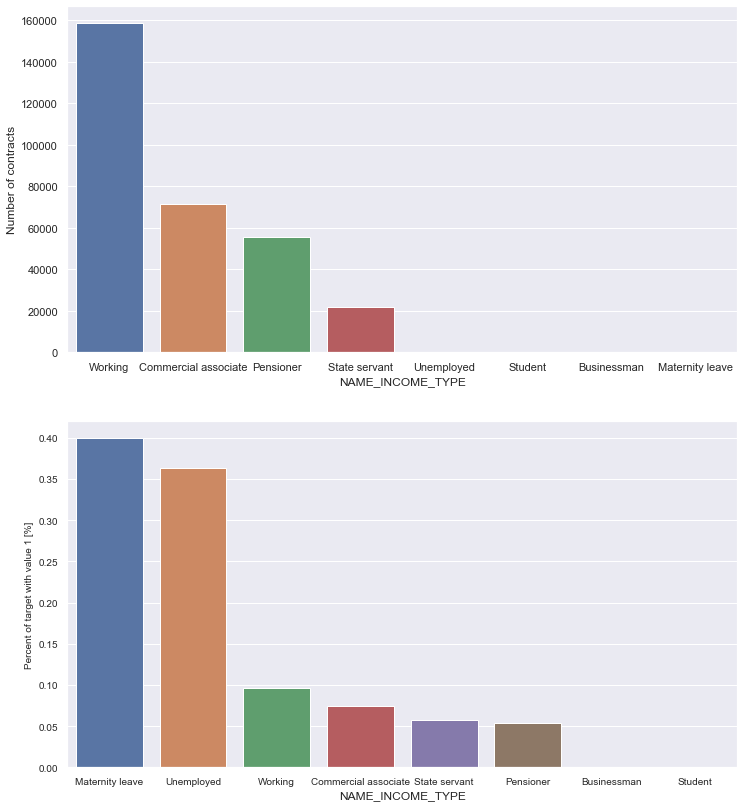

In [60]:
plot_stats('NAME_INCOME_TYPE',False,False)

**Observations :** Les crédits sont plus facilement accordés aux personnes étant en situation de travail.

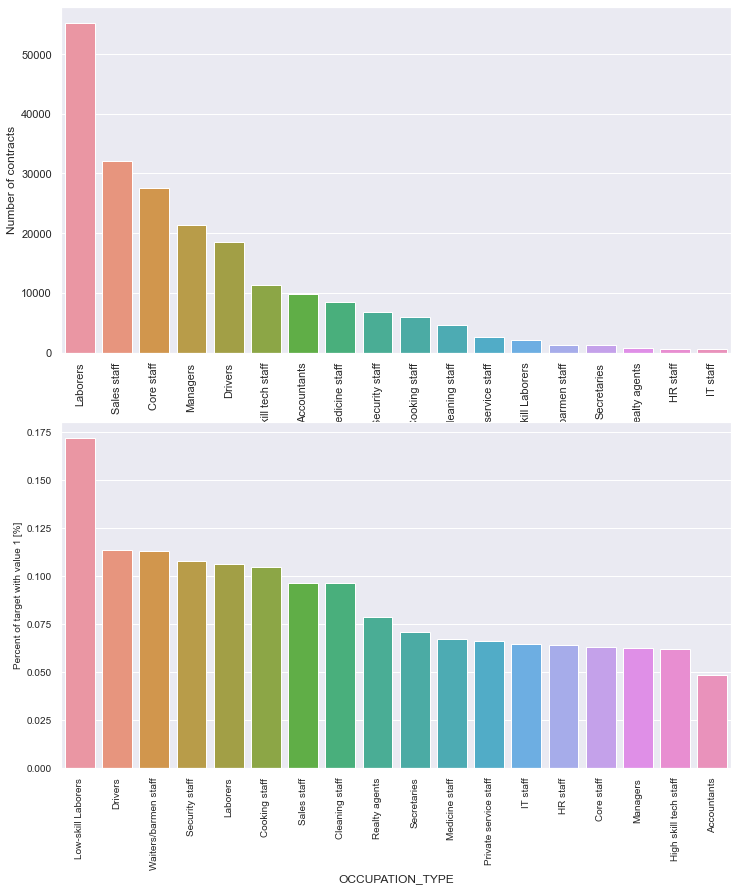

In [61]:
plot_stats('OCCUPATION_TYPE',True, False)

**Observations :** Les crédits sont plus facilement accordés aux personnes étant en situation d'ouvriers ou salariés.

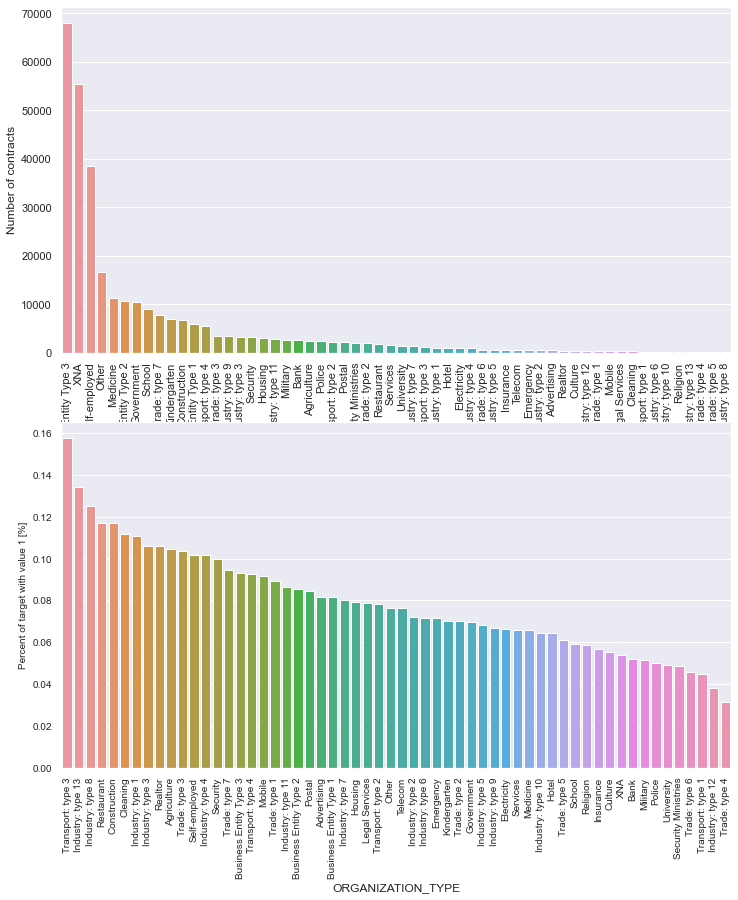

In [62]:
plot_stats('ORGANIZATION_TYPE',True, False)

**Observations :** Les crédits sont plus facilement accordés aux personnes travaillant dans le secteur 3.

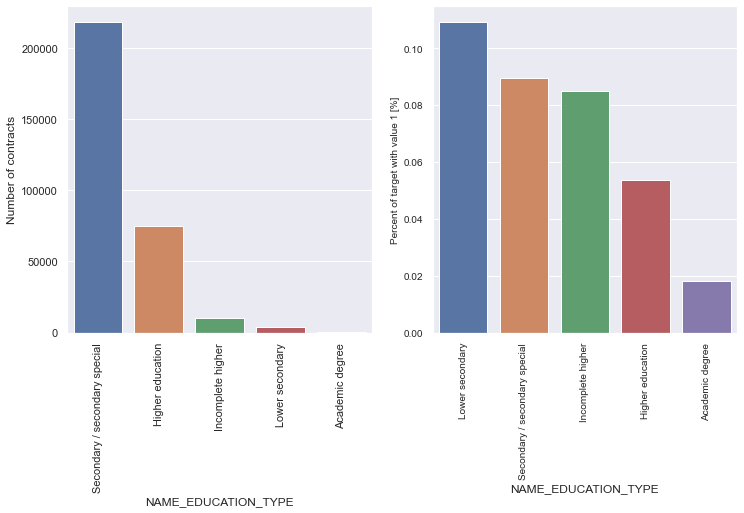

In [63]:
plot_stats('NAME_EDUCATION_TYPE',True)

**Observations :** Les crédits sont plus facilement accordés aux personnes issues d'une éducation secondaire. 

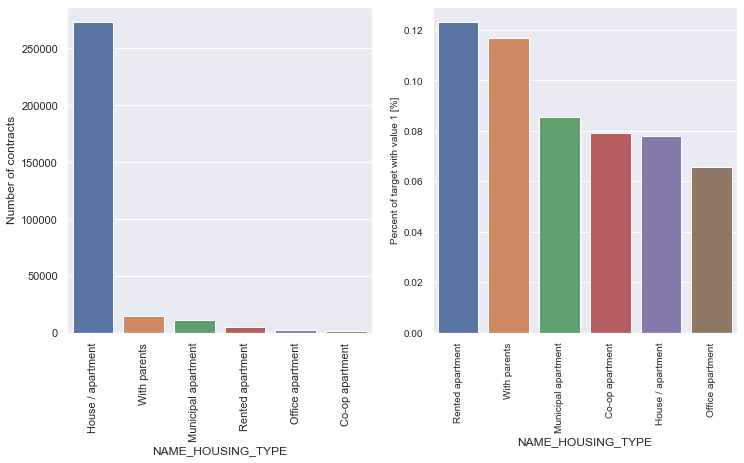

In [64]:
plot_stats('NAME_HOUSING_TYPE',True)

**Observations :** Les crédits sont plus facilement accordés aux personnes dans des maisons ou appartements que des personnes vivants chez leurs parents ou dans des locatifs.

In [65]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = application_train_test_df.loc[application_train_test_df['TARGET'] != 0]
    t0 = application_train_test_df.loc[application_train_test_df['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

<Figure size 432x288 with 0 Axes>

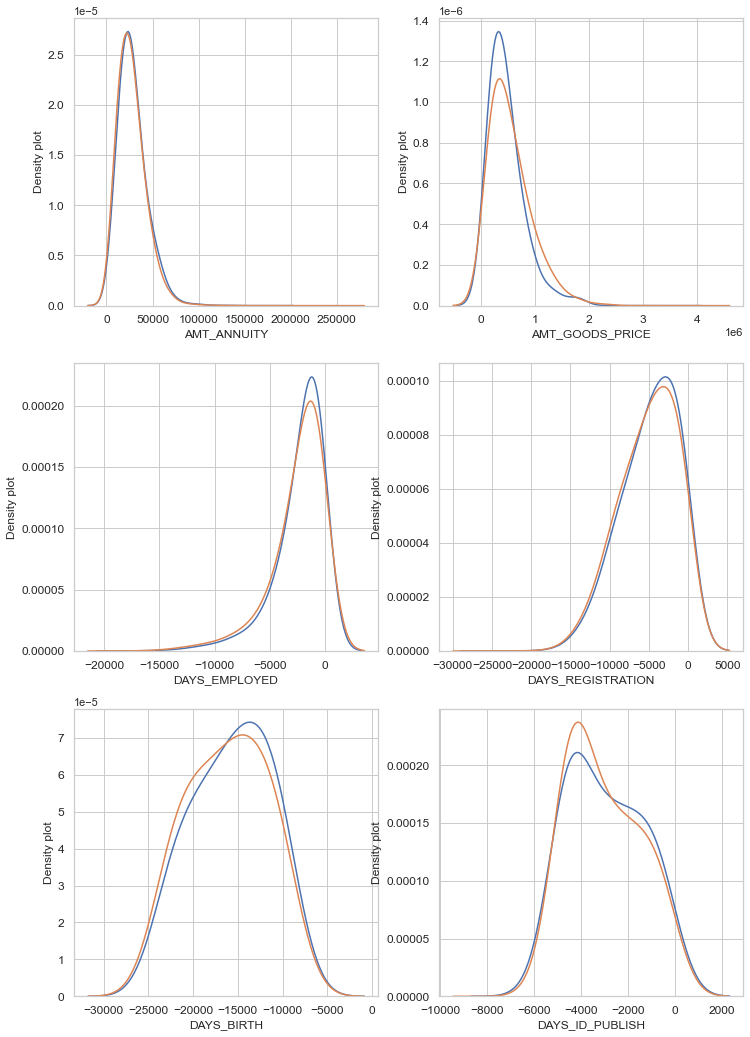

In [66]:
var = ['AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED', 'DAYS_REGISTRATION','DAYS_BIRTH','DAYS_ID_PUBLISH']
plot_distribution_comp(var,nrow=3)

**Observations :** La densité pour la variable TARGET entre les crédits acceptés et refusés sont relativement proches pour ces variables. 

In [67]:
#Plot distribution of one feature
def plot_distribution(feature, title):
    plt.figure(figsize=(20,6))

    t0 = application_train_test_df.loc[application_train_test_df['TARGET'] == 0]
    t1 = application_train_test_df.loc[application_train_test_df['TARGET'] == 1]

    
    sns.kdeplot(t0[feature].dropna(), color='blue', label="TARGET = 0")
    sns.kdeplot(t1[feature].dropna(), color='red', label="TARGET = 1")
    plt.title(title)
    plt.ylabel('')
    plt.legend()
    plt.show()   

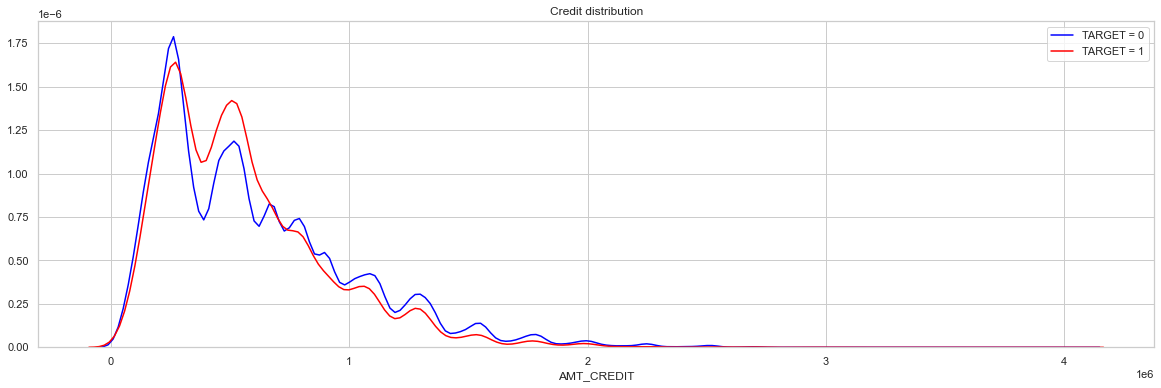

                                   -------------------------------------------------------


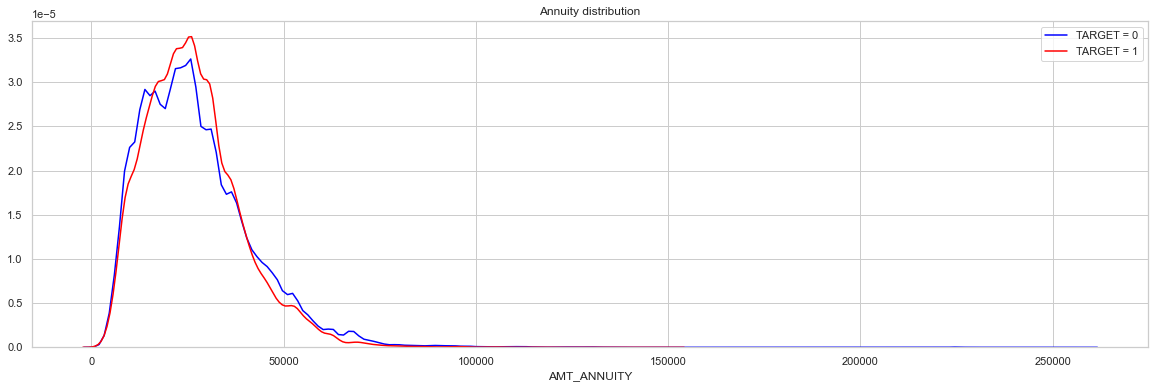

                                   -------------------------------------------------------


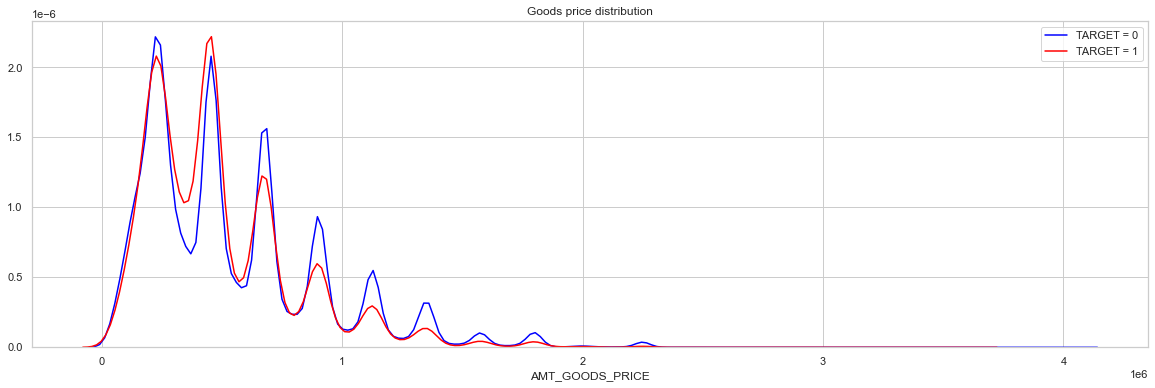

                                   -------------------------------------------------------


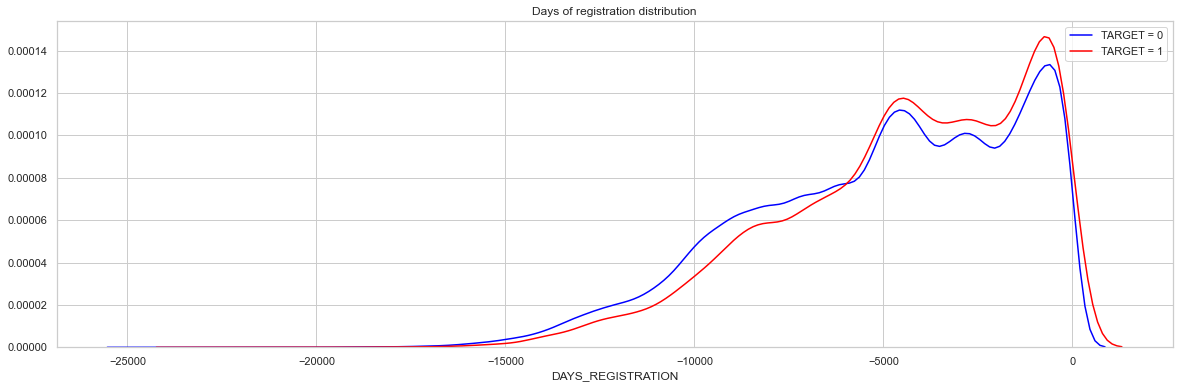

In [68]:
plot_distribution('AMT_CREDIT', "Credit distribution")
print("                                   -------------------------------------------------------")
plot_distribution('AMT_ANNUITY', "Annuity distribution")
print("                                   -------------------------------------------------------")
plot_distribution('AMT_GOODS_PRICE', "Goods price distribution")
print("                                   -------------------------------------------------------")
plot_distribution('DAYS_REGISTRATION', "Days of registration distribution")
print("        ")

**Observations :** La densité pour la variable TARGET entre les crédits acceptés et refusés sont relativement proches pour ces variables. 

In [69]:
application_bureau_train = application_train_df.merge(bureau_df, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [70]:
application_bureau_train.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY_x',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION

In [71]:
def plot_b_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = application_bureau_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_bureau_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

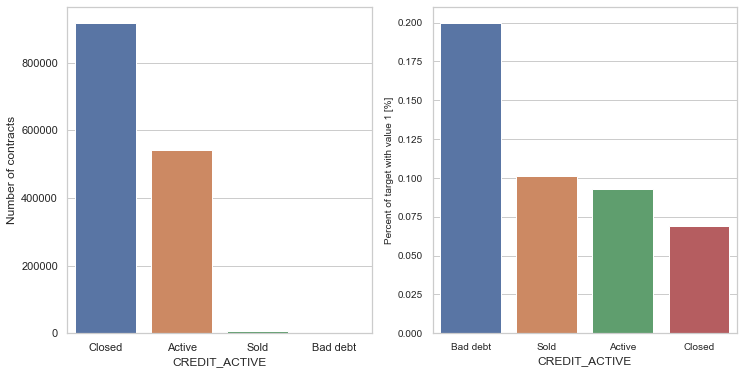

In [72]:
plot_b_stats('CREDIT_ACTIVE')

**Observations :** Il y a davantage de crédits remboursés que de crédits actifs. 

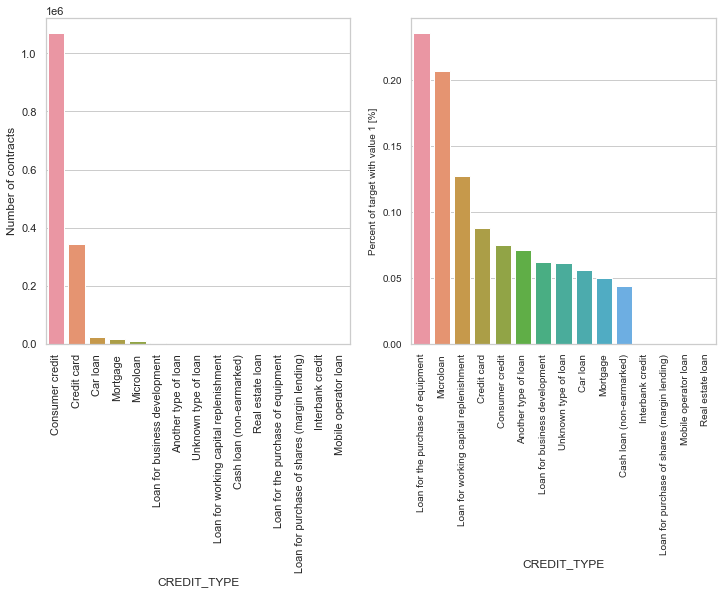

In [73]:
plot_b_stats('CREDIT_TYPE', True, True)

**Observations :** La plupart des crédits sont des crédits à la consommation. 

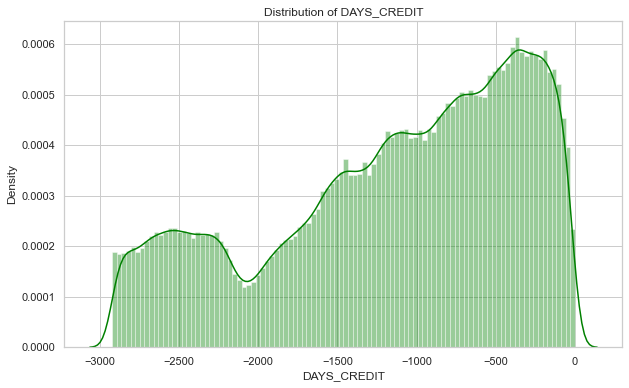

In [74]:
def plot_b_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(application_bureau_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show() 
    
plot_b_distribution('DAYS_CREDIT','green')

**Observations :** Il y a plus de crédits étalés sur une période de 1 an à 4 ans que de crédits établis sur plusieurs années au-delà de 5 ans.

In [75]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_b_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = application_bureau_train.loc[application_bureau_train['TARGET'] != 0]
    t0 = application_bureau_train.loc[application_bureau_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

<Figure size 432x288 with 0 Axes>

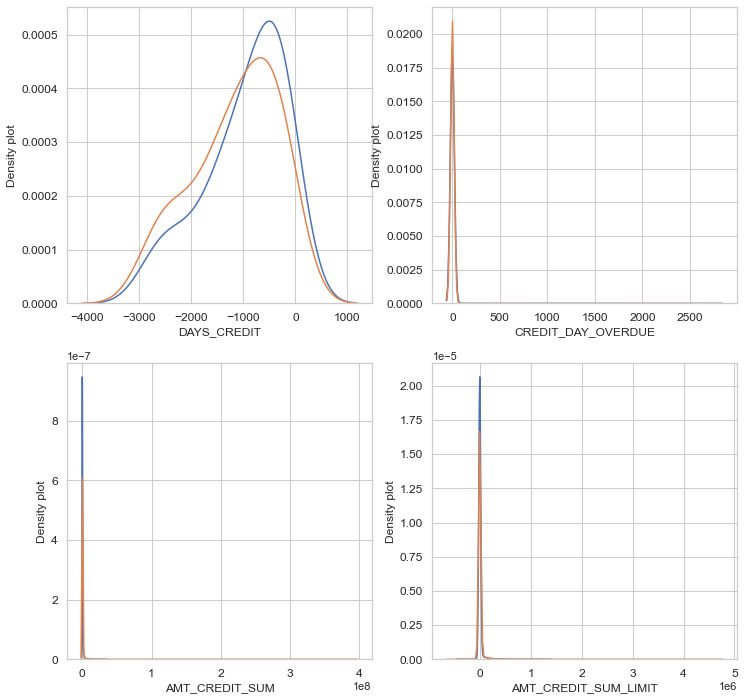

In [76]:
var = ['DAYS_CREDIT','CREDIT_DAY_OVERDUE','AMT_CREDIT_SUM','AMT_CREDIT_SUM_LIMIT']

plot_b_distribution_comp(var, nrow=2)


**Observations :** La densité pour la variable TARGET entre les crédits acceptés et refusés sont relativement proches pour ces variables. 

In [77]:
application_prev_train = application_train_df.merge(previous_application_df, 
                                                 left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [78]:
def plot_p_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = application_prev_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_prev_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

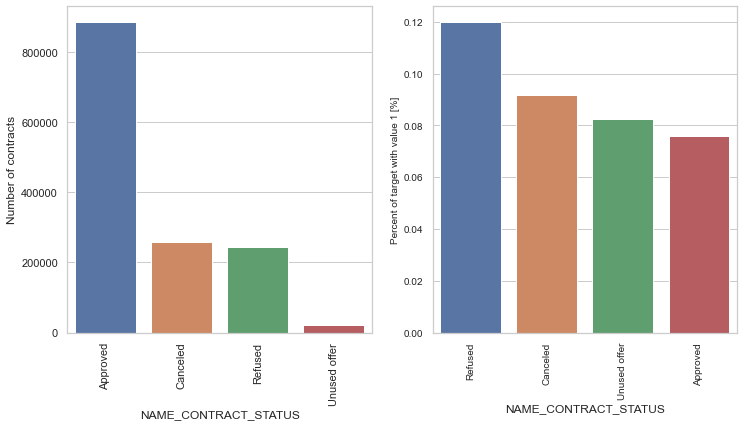

In [79]:
plot_p_stats('NAME_CONTRACT_STATUS', True, True)

**Observations :** La majorité des crédits à la consommation sont acceptés pour les individus.

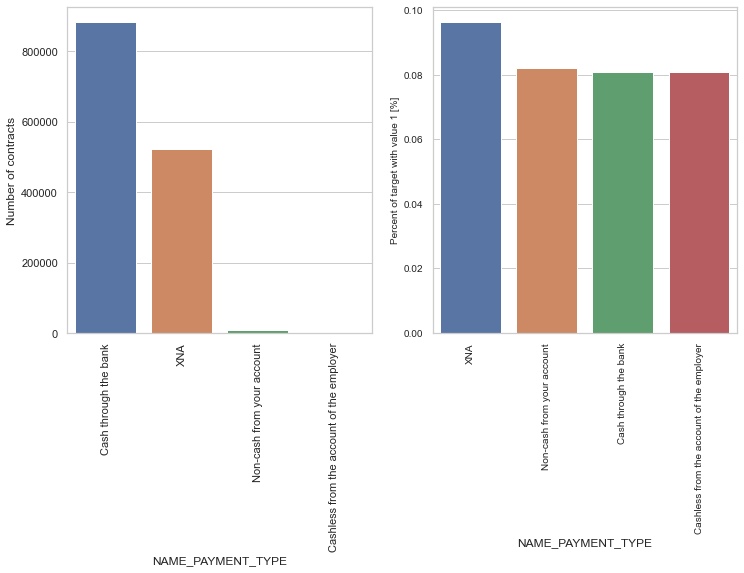

In [80]:
plot_p_stats('NAME_PAYMENT_TYPE', True, True)

**Observations :** La plupart des crédits sont remboursés via la banque. 

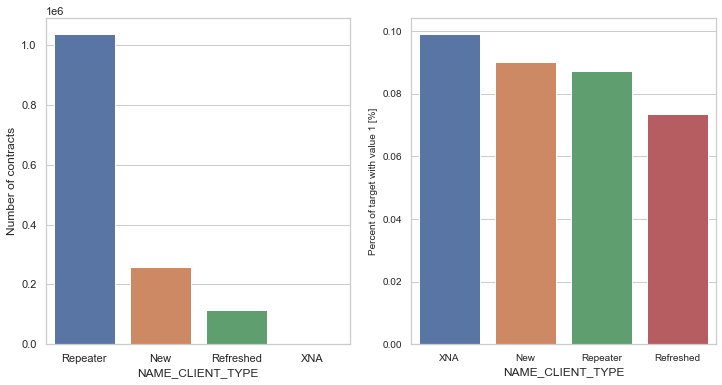

In [81]:
plot_p_stats('NAME_CLIENT_TYPE')

**Observations :** Les clients récurrents ont davantage de crédits que les nouveaux clients.  

### Traitement des valeurs manquantes

In [82]:
# Setting the threshold at 60% missing values 
threshold_dt = len(application_train_test_df) * 0.6
int(threshold_dt)

213750

In [83]:
print("In data:\n")
print(application_train_test_df.columns[application_train_test_df.isnull().sum() > int(threshold_dt)])

In data:

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')


In [84]:
application_train_test_df['TARGET'].value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [85]:
train_new = application_train_test_df.dropna(axis=1, thresh=threshold_dt)
print(train_new.shape)

(356251, 203)


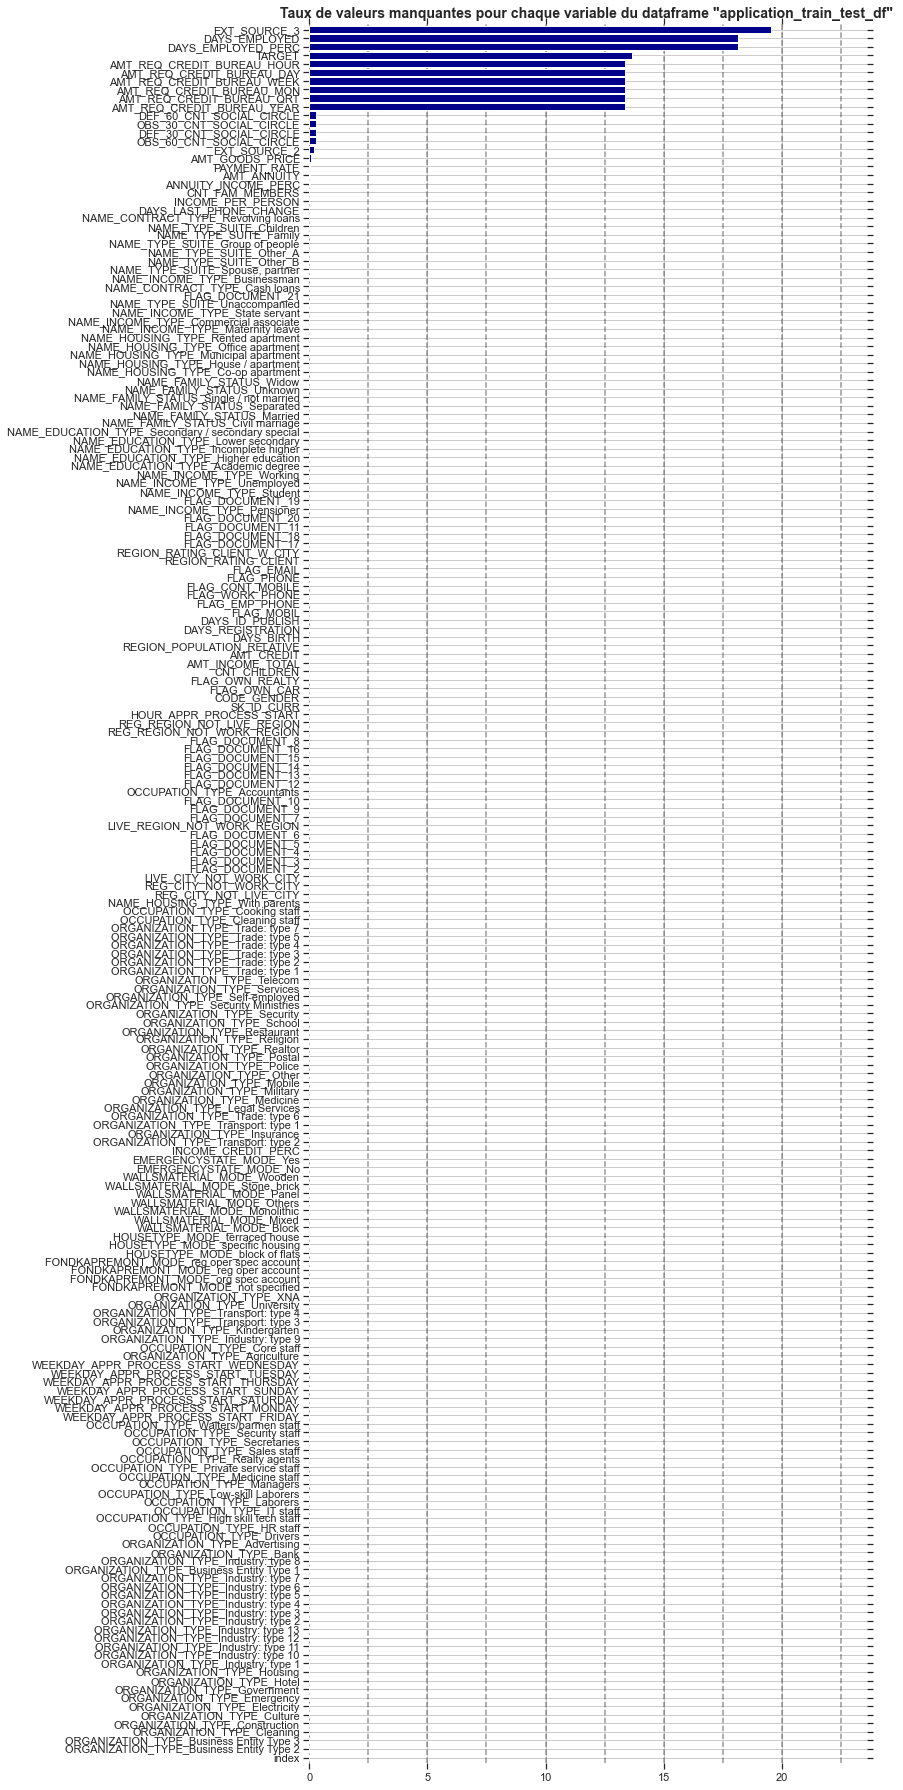

In [86]:
# For each variable, we look at the percentage of missing data after setting the treshold
size = train_new.shape
nan_values = train_new.isna().sum()

nan_values = nan_values.sort_values(ascending=True) * 100 / size[0]

ax = nan_values.plot(
    kind="barh", figsize=(10, 32), color="darkblue", zorder=2, width=0.85
)

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.tick_params(
    axis="both",
    which="both",
    bottom="off",
    top="off",
    labelbottom="on",
    left="off",
    right="off",
    labelleft="on",
)
ax.set_title(
    'Taux de valeurs manquantes pour chaque variable du dataframe "application_train_test_df" ',
    fontsize=14,
    fontweight="bold",
)
vals = ax.get_xticks()

for tick in vals:
    ax.axvline(x=tick, linestyle="dashed", alpha=0.4, color="black", zorder=1)

In [87]:
nan_check(train_new)[:30]

,Total,%
EXT_SOURCE_3,69633,19.55
DAYS_EMPLOYED_PERC,64648,18.15
DAYS_EMPLOYED,64648,18.15
TARGET,48744,13.68
AMT_REQ_CREDIT_BUREAU_WEEK,47568,13.35
AMT_REQ_CREDIT_BUREAU_MON,47568,13.35
AMT_REQ_CREDIT_BUREAU_DAY,47568,13.35
AMT_REQ_CREDIT_BUREAU_HOUR,47568,13.35
AMT_REQ_CREDIT_BUREAU_QRT,47568,13.35
AMT_REQ_CREDIT_BUREAU_YEAR,47568,13.35


In [88]:
print("Nb of columns in the training sample: " + str(len(nan_check(train_new))))

print("Nb of columns in the training sample with missing values: " + 
      str(len(nan_check(train_new)[nan_check(train_new)['Total']!=0])))
	  
	  

Nb of columns in the training sample: 203
Nb of columns in the training sample with missing values: 22


In [89]:
train_new.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623


In [90]:
train_new.drop('index', inplace=True, axis=1)

C:\Users\robin\AppData\Local\Temp\ipykernel_10356\74614561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new.drop('index', inplace=True, axis=1)


### Prétraitement des données 

In [91]:
#A décommenter
from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler()

In [92]:
#A décommenter 
# Imputation of missing data by the median 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
train_new.iloc[:,:] = imputer.fit_transform(train_new)

C:\Users\robin\AppData\Local\Temp\ipykernel_10356\299558617.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new.iloc[:,:] = imputer.fit_transform(train_new)


In [93]:
data_train = train_new[train_new['SK_ID_CURR'].isin(train_new.SK_ID_CURR)]
data_test = train_new[train_new['SK_ID_CURR'].isin(train_new.SK_ID_CURR)]

data_test = data_test.drop('TARGET', axis=1)

In [94]:
train_new.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,...,0.0,1.0,0.0,1.0,0.0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,1.0,0.0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.152418,0.236842,121500.0,0.179963,0.042623


In [95]:
data_train.set_index('SK_ID_CURR', inplace=True)
data_test.set_index('SK_ID_CURR', inplace=True)

In [96]:
print('Training Features shape with categorical columns: ', data_train.shape)
print('Testing Features shape with categorical columns: ', data_test.shape)

Training Features shape with categorical columns:  (356251, 201)
Testing Features shape with categorical columns:  (356251, 200)


In [97]:
# Create a subset with the 52 most important features 
# relevant_data_for_dashboard = data_train[
#     ['OBS_30_CNT_SOCIAL_CIRCLE',
#  'EXT_SOURCE_3',
#  'OBS_60_CNT_SOCIAL_CIRCLE',
#  'AMT_REQ_CREDIT_BUREAU_YEAR',
#  'EXT_SOURCE_2',
#  'CNT_CHILDREN',
#  'index',
#  'CNT_FAM_MEMBERS',
#  'REGION_RATING_CLIENT_W_CITY',
#  'REGION_RATING_CLIENT',
#  'AMT_REQ_CREDIT_BUREAU_QRT',
#  'DEF_30_CNT_SOCIAL_CIRCLE',
#  'PAYMENT_RATE',
#  'DAYS_LAST_PHONE_CHANGE',
#  'REGION_POPULATION_RELATIVE',
#  'DAYS_ID_PUBLISH',
#  'AMT_GOODS_PRICE',
#  'DAYS_BIRTH',
#  'HOUR_APPR_PROCESS_START',
#  'DEF_60_CNT_SOCIAL_CIRCLE',
#  'AMT_REQ_CREDIT_BUREAU_MON',
#  'AMT_CREDIT',
#  'INCOME_PER_PERSON',
#  'AMT_INCOME_TOTAL',
#  'DAYS_REGISTRATION',
#  'AMT_ANNUITY',
#  'ANNUITY_INCOME_PERC',
#  'DAYS_EMPLOYED',
#  'INCOME_CREDIT_PERC',
#  'DAYS_EMPLOYED_PERC',
#  'FLAG_PHONE',
#  'CODE_GENDER',
#  'FLAG_OWN_CAR',
#  'NAME_EDUCATION_TYPE_Secondary / secondary special',
#  'ORGANIZATION_TYPE_Business Entity Type 3',
#  'FLAG_OWN_REALTY',
#  'NAME_EDUCATION_TYPE_Higher education',
#  'FLAG_DOCUMENT_3',
#  'FLAG_EMAIL',
#  'OCCUPATION_TYPE_Laborers',
#  'NAME_INCOME_TYPE_Working',
#  'ORGANIZATION_TYPE_Self-employed',
#  'NAME_FAMILY_STATUS_Married',
#  'FLAG_WORK_PHONE',
#  'NAME_TYPE_SUITE_Unaccompanied',
#  'EMERGENCYSTATE_MODE_No',
#  'NAME_FAMILY_STATUS_Single / not married',
#  'FONDKAPREMONT_MODE_reg oper account',
#  'WEEKDAY_APPR_PROCESS_START_TUESDAY',
#  'HOUSETYPE_MODE_block of flats',
#  'WEEKDAY_APPR_PROCESS_START_WEDNESDAY']]

In [98]:
TARGET = data_train.TARGET # Save our TARGET variable
# data_train.drop('TARGET', axis=1, inplace=True) # Remove TARGET from train

In [99]:
# Separate training data for columns names
target = TARGET
features = data_train
print('x_train data shape: ', features.shape)
print('y_train data shape: ', target.shape)

x_train data shape:  (356251, 201)
y_train data shape:  (356251,)


In [100]:
target_sample = target
target_sample.shape

(356251,)

In [101]:
print(data_train.shape)
print(data_test.shape)

(356251, 201)
(356251, 200)


In [102]:
features_sample = features
features_sample.shape

(356251, 201)

In [103]:
#On conserve les données 
relevant_data_for_dashboard.head()

In [104]:
relevant_data_for_dashboard = relevant_data_for_dashboard.merge(target, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')
relevant_data_for_dashboard.head()

In [105]:
relevant_data_for_dashboard = relevant_data_for_dashboard.iloc[0:20000].copy()

In [106]:
relevant_data_for_dashboard = relevant_data_for_dashboard.to_csv("relevant_data_for_dashboard.csv",index=True)

In [107]:
from sklearn.impute import SimpleImputer

In [108]:
from sklearn.preprocessing import MinMaxScaler

In [109]:
# A décommenter
# Fit scaler to our training data
# scaler = MinMaxScaler(feature_range = (0, 1))
# scaler.fit(data_train)
# scaled_train = scaler.transform(data_train)

In [110]:
# A décommenter
# scaler = MinMaxScaler(feature_range = (0, 1))
# scaler.fit(data_test)
# scaled_test = scaler.transform(data_test)

In [111]:
#A décommenter
# In order to keep our column names we include scaled_values to our train/test dataframes like this
# data_train = pd.DataFrame(scaled_train, index=data_train.index, columns=data_train.columns)
# data_test = pd.DataFrame(scaled_test, index=data_test.index, columns=data_test.columns)

In [112]:
data_train.shape

(356251, 201)

In [113]:
data_test.shape

(356251, 200)

In [114]:
TARGET.shape

(356251,)

In [115]:
data_train.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.0,1.0,0.0,1.0,0.0,0.067329,0.498036,202500.0,0.121978,0.060749
100003.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.0,0.0,0.0,1.0,0.0,0.070862,0.208736,135000.0,0.132217,0.027598
100004.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.0,0.0,0.0,0.0,0.0,0.011814,0.500000,67500.0,0.100000,0.050000
100006.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.159905,0.431748,67500.0,0.219900,0.094941
100007.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.152418,0.236842,121500.0,0.179963,0.042623


In [116]:
#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
# from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.dummy import DummyClassifier

In [117]:
#Transformation des données 
# Pipeline de standardisation et d'imputation des valeurs manquantes
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

var_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])

In [118]:
# Separation of the dataset into training and test sets  
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.2, random_state=42)

In [119]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((285000, 201), (71251, 201), (285000,), (71251,))

In [120]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 19859 
Label 0, Before using SMOTE: 265141 


In [121]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from collections import Counter

In [122]:
# Dictionnaire de classifieurs 
classifiers_1 = { 'Dummy Classifier': DummyClassifier(),
                  'Logistic Regression': LogisticRegression(),
                  'Random Forest': RandomForestClassifier(n_estimators=100),
                  'Xgboost': XGBClassifier(),
                  'LGBM': LGBMClassifier()
              }

In [123]:
# Pipeline de transformations + classification
def define_pipeline(preprocessor, classifier) :
    
    pipe = Pipeline([("preprocess", preprocessor),
                     ("regressor", classifier),
                    ])
    return pipe

In [124]:
def plot_roc_curve(classifiers, var_pipeline, X, y, n_splits=5, fit=True):

    kf = KFold(n_splits=n_splits)    
    for name_clf, clf in classifiers.items():
        print(name_clf)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for i, (train, test) in enumerate(kf.split(X, y)):

            full_pipeline = define_pipeline(var_pipeline, clf)
            
            if fit :
                full_pipeline.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = full_pipeline.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            auc_ = auc(fpr, tpr)

            aucs.append(auc_)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Dummy Classifier
Logistic Regression


C:\Users\robin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\robin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Random Forest
Xgboost
LGBM


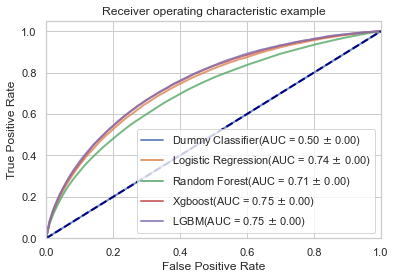

In [125]:
# Affichage de la courbe ROC pour les différents modèles testés
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
plot_roc_curve(classifiers_1, var_pipeline, data_train.drop(columns="TARGET"), data_train["TARGET"])

### Modélisation avec un jeu de données déséquilibré et rééquilibré

In [126]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from collections import Counter

In [127]:
# Classifier dictionary for the initial dataset
classifiers = {
    "DummyClassifier_most_frequent": DummyClassifier(strategy='most_frequent', random_state=0),
    "LogisticRegression": LogisticRegression(solver = 'lbfgs', max_iter=1000),
    "LGBMClassifier": LGBMClassifier(),
    "XGBClassifier": XGBClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier()
}

In [128]:
# A décommenter
# Classifier dictionary for the rebalanced dataset with the "classweight" argument
# classifiers_classweight = {
#     "LogisticRegression": LogisticRegression(solver = 'lbfgs', max_iter=1000, class_weight='balanced'),
#     "LGBMClassifier": LGBMClassifier(class_weight='balanced'),
#     "XGBClassifier": XGBClassifier(class_weight='balanced'),
#     "RandomForestClassifier": RandomForestClassifier(class_weight='balanced'),
# }

In [129]:
# A décommenter en premier car contient des NAN (need Pipeline)
# df_models = pd.DataFrame(columns=['model', 'run_time', 'avg_pre', 'avg_pre_std', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1'])

# for key in classifiers:

#     print('*',key)

#     start_time = time.time()

#     classifier = classifiers[key]
#     model = classifier.fit(X_train, y_train)
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
#     scorer = make_scorer(average_precision_score)
#     cv_scores = cross_val_score(model, X_test, y_test, cv=5, scoring=scorer)
#     y_pred = model.predict(X_test)

#     row = {'model': key,
#            'run_time': format(round((time.time() - start_time)/60,2)),
#            'avg_pre': cv_scores.mean(),
#            'avg_pre_std': cv_scores.std(),
#            'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
#            'Accuracy': accuracy_score(y_test, model.predict(X_test)),
#            'Precision': precision_score(y_test, model.predict(X_test)),
#            'Recall': recall_score(y_test, model.predict(X_test)),
#            'F1': f1_score(y_test, model.predict(X_test))
#     }

#     df_models = df_models.append(row, ignore_index=True)

In [130]:
# A décommenter en premier car contient des NAN (need Pipeline)
# Model results with the initial dataset
# df_models.head(10).sort_values(by='AUC')

In [131]:
# A décommenter 
# df_models_classweight = pd.DataFrame(columns=['model', 'run_time', 'avg_pre', 'avg_pre_std', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1'])

# for key in classifiers_classweight:

#     print('*',key)

#     start_time = time.time()

#     classifier = classifiers_classweight[key]
#     model = classifier.fit(X_train, y_train)
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
#     scorer = make_scorer(average_precision_score)
#     cv_scores = cross_val_score(model, X_test, y_test, cv=5, scoring=scorer)
#     y_pred = model.predict(X_test)

#     row = {'model': key,
#            'run_time': format(round((time.time() - start_time)/60,2)),
#            'avg_pre': cv_scores.mean(),
#            'avg_pre_std': cv_scores.std(),
#            'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
#            'Accuracy': accuracy_score(y_test, model.predict(X_test)),
#            'Precision': precision_score(y_test, model.predict(X_test)),
#            'Recall': recall_score(y_test, model.predict(X_test)),
#            'F1': f1_score(y_test, model.predict(X_test))
#     }

#     df_models_classweight = df_models_classweight.append(row, ignore_index=True)

In [132]:
# A décommenter
# Model results with the rebalanced dataset with the "classweight" argument
# df_models_classweight.head(10).sort_values(by='AUC')

In [133]:
# A décommenter en premier car contient des NAN (need Pipeline)
# Comparison of results between an unbalanced and rebalanced dataset with SMOTE 
# df_result = pd.DataFrame(columns=['model', 'tp', 'tn', 'fp', 'fn', 'correct', 'incorrect',
#                                   'accuracy', 'precision', 'recall', 'f1', 'roc_auc','avg_pre'])

# classifier = XGBClassifier(random_state=123)
# model = classifier.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred)
# avg_precision = average_precision_score(y_test, y_pred)

# row = {'model': 'XGBClassifier without SMOTE',
#         'tp': tp,
#         'tn': tn,
#         'fp': fp,
#         'fn': fn,
#         'correct': tp+tn,
#         'incorrect': fp+fn,
#         'accuracy': round(accuracy,3),
#         'precision': round(precision,3),
#         'recall': round(recall,3),
#         'f1': round(f1,3),
#         'roc_auc': round(roc_auc,3),
#         'avg_pre': round(avg_precision,3),
#     }

# df_result = df_result.append(row, ignore_index=True)
# df_result.head()

In [134]:
data_train_copy = data_train.copy()

In [135]:
TARGET_copy = TARGET.copy()

In [136]:
# Cross Validation before using SMOTE()
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

# kf = KFold(n_splits=5)

# for fold, (train_index, test_index) in enumerate(kf.split(data_train_copy), 1):
#     X_train = data_train_copy[train_index]
#     y_train = TARGETçcopy[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
#     X_test = data_train_copy[test_index]
#     y_test = TARGET_copy[test_index]  # See comment on ravel and  y_train
#     sm = SMOTE()
#     X_train_smt, y_train_smt = sm.fit_sample(X_train, y_train)
#     model1 = lgb.LGBMClassifier()  # Choose a model here
#     model1.fit(X_train_smt, y_train_smt )  
#     y_pred = model1.predict(X_test)
#     print(f'For fold {fold}:')
#     print(f'Accuracy: {model1.score(X_test, y_test)}')
#     print(f'f-score: {f1_score(y_test, y_pred)}')

In [137]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# X = data_train.copy()
# y = TARGET.copy()

# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=0.2,
#                                                     stratify=y,
#                                                     random_state=11)

# smote = SMOTE(random_state = 11)
# X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)
# pipeline = Pipeline(steps = [['scaler', MinMaxScaler()],
#                              ['classifier', LogisticRegression(random_state=11,
#                                                                max_iter=1000)]])

# stratified_kfold = StratifiedKFold(n_splits=3,
#                                        shuffle=True,
#                                        random_state=11)
    
# param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# grid_search = GridSearchCV(estimator=pipeline,
#                            param_grid=param_grid,
#                            scoring='roc_auc',
#                            cv=stratified_kfold,
#                            n_jobs=-1)

# grid_search.fit(X_train_smt, y_train_smt)
# cv_score = grid_search.best_score_
# test_score = grid_search.score(X_test, y_test)
# print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [138]:
# kf = KFold(n_splits=10)

In [139]:
# example_params = {
#         'n_estimators': 100,
#         'max_depth': 5,
#         'random_state': 13
#     }

# def score_model(model, params, cv=None):
#     """
#     Creates folds manually, and upsamples within each fold.
#     Returns an array of validation (recall) scores
#     """
#     if cv is None:
#         cv = KFold(n_splits=5, random_state=42)

#     smoter = SMOTE(random_state=42)
    
#     scores = []

#     for train_fold_index, val_fold_index in cv.split(X_train_data, y_train_data):
#         # Get the training data
#         X_train_fold, y_train_fold = X_train_data[train_fold_index], y_train_data[train_fold_index]
#         # Get the validation data
#         X_val_fold, y_val_fold = X_train_data[val_fold_index], y_train_data[val_fold_index]

#         # Upsample only the data in the training section
#         X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
#                                                                            y_train_fold)
#         # Fit the model on the upsampled training data
#         model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
#         # Score the model on the (non-upsampled) validation data
#         score = recall_score(y_val_fold, model_obj.predict(X_val_fold))
#         scores.append(score)
#     return np.array(scores)

# # Example of the model in action
# score_model(XGBClassifier, example_params, cv=kf)

In [140]:
# params = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [4, 6, 10, 12],
#     'random_state': [13]
# }

In [141]:
# score_tracker = []
# for n_estimators in params['n_estimators']:
#     for max_depth in params['max_depth']:
#         example_params = {
#             'n_estimators': n_estimators,
#             'max_depth': max_depth,
#             'random_state': 13
#         }
#         example_params['recall'] = score_model(XGBClassifier, 
#                                                example_params, cv=kf).mean()
#         score_tracker.append(example_params)
        
# # What's the best model?
# sorted(score_tracker, key=lambda x: x['recall'], reverse=True)[0]

In [142]:
# X_train_upsample, y_train_upsample = SMOTE(random_state=42).fit_resample(X_train, y_train)

In [143]:
# name 'X_train_upsample' is not defined
# xg = XGBClassifier(n_estimators=50, max_depth=4, random_state=13)
# xg.fit(X_train_upsample, y_train_upsample)
# recall_score(y_test,xg.predict(X_test))

In [144]:
# Packages hyperopt pour la séléction d'hyperparamètres
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [145]:
# 5.1 Fonction d'optimisation pour le choix des hyperparamètres
skf = StratifiedKFold(n_splits=5)
def model_v1(predictor, pipeline, features, eval_metric, cv=skf):
    
    
    # Extract the ids
    train_ids = features.index

    # Extract the targets for training
    targets = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns=['TARGET'])
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Apply the pipeline
    features = pipeline.fit_transform(features)
    targets = np.array(targets)    
    
    # Increase the data to get a bigger proportion of positif targets
    sm = SMOTE(random_state=42, sampling_strategy=0.2) # the ratio is chosen
    # to correspond to the pareto law with the 80%/20% ratio
    features_res, targets_res = sm.fit_resample(features, targets.ravel())  
    
    
    def optim_score(params,
                    model=predictor,
                    x_train=features_res,
                    y_train=targets_res,
                    cv=cv,
                    eval_metric=eval_metric):

        # the function gets a set of variable parameters in "param"
        params_model = {'n_estimators': int(params['n_estimators']), 
                        'max_depth': int(params['max_depth']), 
                        'learning_rate': params['learning_rate'],
                        'subsample': params['subsample'],
                        'colsample_bytree': params['colsample_bytree'],
                        'num_leaves': int(params['num_leaves']),
                        'reg_alpha': params['reg_alpha'],
                        'reg_lambda': params['reg_lambda'],
        }

        # asssigne les paramètres du modèle
        model.set_params(**params_model)
        
        # Seuil de solvabilité
        threshold = params['solvability_threshold']

        # Cross-validation à 5 passes : retourne le score de probabilité
        y_proba = cross_val_predict(model,
                                    x_train,
                                    y_train,
                                    method='predict_proba',
                                    cv=cv)[:, 1]
       
        # Si proba > seuil alors la prédiction est positive : 1
        y_pred = (y_proba > threshold)
        y_pred = np.array(y_pred > 0) * 1
        
        # Calcul du score suivant la métrique utilisé
        score = eval_metric(y_train, y_pred)

        return 1 - score # Retourne le score
    
   # possible values of parameters
    space={'n_estimators': hp.quniform('n_estimators', 200, 2000, 200),
           'max_depth' : hp.quniform('max_depth', 2, 30, 2),
           'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
           'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
           'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
           'num_leaves': hp.quniform('num_leaves', 4, 100, 4),
           'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
           'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1),
           'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
    }


    best=fmin(fn=optim_score, # function to optimize
              space=space, 
              algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
              max_evals=10, # maximum number of iterations
    )

    # computing the score on the test set
    predictor.set_params(
                   n_estimators=int(best['n_estimators']),
                   max_depth=int(best['max_depth']),
                   learning_rate=best['learning_rate'],
                   subsample=best['subsample'],           
                   colsample_bytree=best['colsample_by_tree'],
                   num_leaves=int(best['num_leaves']),
                   reg_alpha=best['reg_alpha'],
                   reg_lambda=best['reg_lambda'],
                    
    )
    
     # Entrainement du modèle sur tout le jeux de données
    predictor.fit(features, targets)

    # Record the best parameters
    best_parameters = best
    
    # Assemblage de pipeline
    full_pipeline = define_pipeline(pipeline, predictor)

    # Record the feature importances
    feature_importance_values = full_pipeline[-1].feature_importances_
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': feature_importance_values})

    return best_parameters, feature_importances, full_pipeline

In [146]:
def model_v2(predictor, pipeline, features, eval_metric, cv=skf):
    
    
    # Extract the ids
    train_ids = features.index

    # Extract the targets for training
    targets = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns=['TARGET'])
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Apply the pipeline
    features = pipeline.fit_transform(features)
    targets = np.array(targets)    
    
    # Increase the data to get a bigger proportion of positif targets
    sm = SMOTE(random_state=42, sampling_strategy=0.2) # the ratio is chosen
    # to correspond to the pareto law with the 80%/20% ratio
    features_res, targets_res = sm.fit_resample(features, targets.ravel())  
    
    
    def optim_score(params,
                    model=predictor,
                    x_train=features_res,
                    y_train=targets_res,
                    cv=cv,
                    eval_metric=eval_metric):

        # the function gets a set of variable parameters in "param"
        params_model = {'n_estimators': int(params['n_estimators']), 
                        'max_depth': int(params['max_depth']), 
                        'learning_rate': params['learning_rate'],
                        'subsample': params['subsample'],
                        'colsample_bytree': params['colsample_bytree'],
                        'num_leaves': int(params['num_leaves']),
                        'reg_alpha': params['reg_alpha'],
                        'reg_lambda': params['reg_lambda'],
        }

        # asssigne les paramètres du modèle
        model.set_params(**params_model)
        
        # Seuil de solvabilité
        threshold = params['solvability_threshold']

        # Cross-validation à 5 passes : retourne le score de probabilité
        y_proba = cross_val_predict(model,
                                    x_train,
                                    y_train,
                                    method='predict_proba',
                                    cv=cv)[:, 1]
       
        # Si proba > seuil alors la prédiction est positive : 1
        y_pred = (y_proba > threshold)
        y_pred = np.array(y_pred > 0) * 1
        
        # Calcul du score suivant la métrique utilisé
        score = eval_metric(y_train, y_pred)

        return 1 - score # Retourne le score
    
   # possible values of parameters
    space={'n_estimators': hp.quniform('n_estimators', 200, 2000, 200),
           'max_depth' : hp.quniform('max_depth', 2, 30, 2),
           'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
           'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
           'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
           'num_leaves': hp.quniform('num_leaves', 4, 100, 4),
           'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
           'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1),
           'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
    }


    best=fmin(fn=optim_score, # function to optimize
              space=space, 
              algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
              max_evals=10, # maximum number of iterations
    )

    # computing the score on the test set
    predictor.set_params(
                   n_estimators=int(best['n_estimators']),
                   max_depth=int(best['max_depth']),
                   learning_rate=best['learning_rate'],
                   subsample=best['subsample'],           
                   colsample_bytree=best['colsample_by_tree'],
                   num_leaves=int(best['num_leaves']),
                   reg_alpha=best['reg_alpha'],
                   reg_lambda=best['reg_lambda'],
                    
    )
    
     # Entrainement du modèle sur tout le jeux de données
    predictor.fit(features, targets)

    # Record the best parameters
    best_parameters = best
    
    # Assemblage de pipeline
    full_pipeline = define_pipeline(pipeline, predictor)

    # Record the feature importances
    feature_importance_values = full_pipeline[-1].feature_importances_
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': feature_importance_values})

    return best_parameters, feature_importances, full_pipeline

In [147]:
# 5.2 Optimisation métrique métier
def Ind_bank(y_true, y_pred, fn_value=-10, fp_value=-1, tp_value=0, tn_value=1):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]
    
    # Gain total
    J = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    
    # Gain maximum
    max_J = (fp + tn)*tn_value + (fn + tp)*tp_value
    
    # Gain minimum
    min_J = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)
    
    return J_normalized  # Retourne la fonction d'évaluation

In [148]:
# Transformations de variables
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline

# Pipeline de standardisation et d'imputation des valeurs manquantes
# var_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', RobustScaler()),
# ])

In [149]:
# Pipeline de transformations + classification
# def define_pipeline(preprocessor, classifier) :
    
#     pipe = Pipeline([("preprocess", preprocessor),
#                      ("regressor", classifier),
#                     ])
#     return pipe

In [150]:
# def plot_roc_curve(classifiers, var_pipeline, X, y, n_splits=5, fit=True):

#     kf = KFold(n_splits=n_splits)    
#     for name_clf, clf in classifiers.items():
#         print(name_clf)
#         tprs = []
#         aucs = []
#         mean_fpr = np.linspace(0, 1, 100)
#         for i, (train, test) in enumerate(kf.split(X, y)):

#             full_pipeline = define_pipeline(var_pipeline, clf)
            
#             if fit :
#                 full_pipeline.fit(X.iloc[train, :], y.iloc[train])

#             y_pred_grd = full_pipeline.predict_proba(X.iloc[test, :])[:, 1]
#             fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_grd)

#             interp_tpr = np.interp(mean_fpr, fpr, tpr)
#             interp_tpr[0] = 0.0
#             tprs.append(interp_tpr)
#             auc_ = auc(fpr, tpr)

#             aucs.append(auc_)

#         mean_tpr = np.mean(tprs, axis=0)
#         mean_tpr[-1] = 1.0
#         mean_auc = auc(mean_fpr, mean_tpr)
#         std_auc = np.std(aucs)
#         plt.plot(mean_fpr, mean_tpr,
#             label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
#             lw=2,
#             alpha=.8)

#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()

In [151]:
best_parameters_0, feature_importance_0, clf_0 = model_v1(LGBMClassifier(),
                                                          var_pipeline,
                                                          data_train,
                                                          eval_metric=Ind_bank)

100%|██████████████████████████████████████████████| 10/10 [24:53<00:00, 149.35s/trial, best loss: 0.18728190800044053]


In [152]:
# Affichage des meilleurs hyper-paramètres pour la métrique bancaire
best_parameters_0

{'colsample_by_tree': 0.9,
 'learning_rate': 0.06582209707513313,
 'max_depth': 12.0,
 'n_estimators': 1000.0,
 'num_leaves': 92.0,
 'reg_alpha': 0.7000000000000001,
 'reg_lambda': 0.7000000000000001,
 'solvability_threshold': 0.42500000000000004,
 'subsample': 0.8}

In [153]:
# Sauvegarde du modèle banking
pickle.dump(clf_0, open('banking_model.md', 'wb'))

Le meilleur seuil de solvabilité est de 0.8, i.e tous les individus dont les valeurs de prédictions sont inférieurs à 0.8 ne sont pas solvables.

In [154]:
#Optimisation de la métrique ROC 
# Optimisation pour la métrique 'roc_auc'
best_parameters_1, feature_importance_1, clf_1 = model_v1(LGBMClassifier(),
                                                          var_pipeline,
                                                          data_train,
                                                          eval_metric=f1_score)

100%|██████████████████████████████████████████████| 10/10 [29:37<00:00, 177.75s/trial, best loss: 0.23530659485580963]


In [155]:
# Affichage des meilleurs hyper-paramètres
best_parameters_1

{'colsample_by_tree': 0.7000000000000001,
 'learning_rate': 0.022746776771047413,
 'max_depth': 10.0,
 'n_estimators': 2000.0,
 'num_leaves': 56.0,
 'reg_alpha': 0.4,
 'reg_lambda': 0.7000000000000001,
 'solvability_threshold': 0.5,
 'subsample': 0.4}

In [156]:
filename = 'banking_model_f1.md'
# Sauvegarde du modèle
pickle.dump(clf_1, open(filename, 'wb'))

In [157]:
# 5.4 Comparaison des résultats pour les deux métriques
# 5.4.1 Matrices de confusion

def plot_heatmap_confusion(y_valid, **y_valid_pred):
    
    plt.figure(1, figsize=(12, 4))
    results = {}
    
    j = 1
    for i, y_pred in y_valid_pred.items():
        
        plt.subplot(1, len(y_valid_pred), j)

        conf_mx = confusion_matrix(y_valid, y_pred)
        results[i] = conf_mx
        mat_conf_df = pd.DataFrame(conf_mx,
                                   columns=["Solvable", "Non Solvable"],
                                   index=["Solvable", "Non Solvable"])
        
        sns.heatmap(mat_conf_df, annot=True, linewidths=.7, fmt='g')

        plt.title(i)
        plt.ylim(0, 2)
        plt.xlabel("Classes prédites")
        plt.ylabel("Classes réelles")
        j+=1
    plt.show()
    
    return results

In [158]:
# On split le jeu d'entrainement en entrainement et test
train_set, valid_set = train_test_split(data_train, test_size=0.2, random_state=42)

In [159]:
y_proba_0 = clf_0.predict_proba(data_train.drop(columns=["TARGET"]))[:, 1]
y_pred_0 = (y_proba_0 > best_parameters_0['solvability_threshold'])
y_pred_0 = np.array(y_pred_0 > 0) * 1

In [160]:
y_proba_1 = clf_1.predict_proba(data_train.drop(columns=["TARGET"]))[:, 1]
y_pred_1 = (y_proba_1 > best_parameters_1['solvability_threshold'])
y_pred_1 = np.array(y_pred_1 > 0) * 1

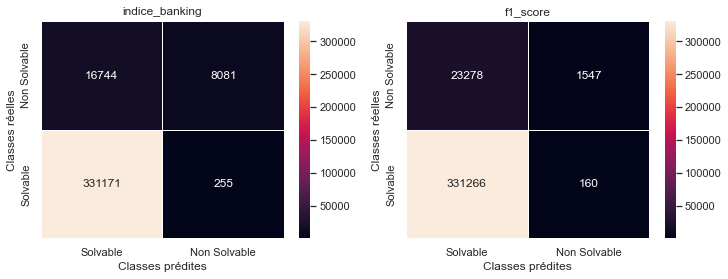

In [161]:
mat_conf = plot_heatmap_confusion(data_train["TARGET"],
                       **{"indice_banking": y_pred_0, "f1_score": y_pred_1})

In [164]:
# Calcule du gain pour la métrique bancaire
J_0 = Ind_bank(data_train["TARGET"], y_pred_0)
# Calcul du gain pour la métrique métier
J_1 = Ind_bank(data_train["TARGET"], y_pred_1)
print("Le gain normalisé pour la métrique banking est de {:.2f} alors qu'il est de {:.2f} pour la métrique technique"
      .format(J_0, J_1))
print("La création de la métrique banking permet un gain de {:.1f}%".format(100*(J_0 - J_1)/J_0))

Le gain normalisé pour la métrique banking est de 0.82 alors qu'il est de 0.74 pour la métrique technique
La création de la métrique banking permet un gain de 8.8%


In [165]:
# 5.4.2 Précision, rappel et roc_auc

def calculate_multi_metrics(clf, x_valid, y_valid, threshold, *metrics):
   
    # liste des scores
    scores = []
    
    # calcule de la probabilité retourné par le modèle
    valid_proba = clf.predict_proba(x_valid)[:, 1]
    # calcule de la prédiction en fonction du threshold
    valid_predictions = (valid_proba > threshold)
    valid_predictions = np.array(valid_predictions > 0) * 1
    
    # Calcule le score pour chaque métrique
    for metric in metrics :
        scores.append(metric(y_valid, valid_predictions))
        
    return scores # retourne la liste des différents scores

In [166]:
# Calcul les scores Accuracy, Recall et Roc_auc
scores_0 = calculate_multi_metrics(clf_0,
                                   data_train.drop(columns=["TARGET"]),
                                   data_train["TARGET"],
                                   best_parameters_0["solvability_threshold"],
                                   *[accuracy_score, recall_score, roc_auc_score])

In [167]:
scores_0

[0.9522836427125818, 0.32551863041289025, 0.6623746139458319]

In [168]:
# Calcul les scores Accuracy, Recall et Roc_auc
scores_1 = calculate_multi_metrics(clf_1,
                                   data_train.drop(columns=["TARGET"]),
                                   data_train["TARGET"],
                                   best_parameters_1["solvability_threshold"],
                                   *[accuracy_score, recall_score, roc_auc_score])

In [169]:
scores_1

[0.9342093074826456, 0.06231621349446123, 0.5309167255641007]

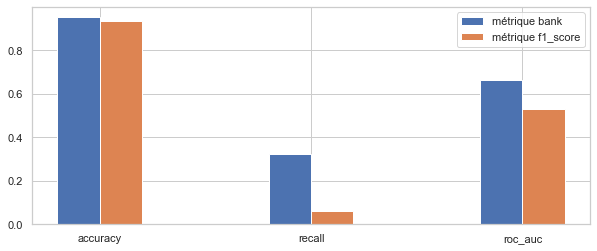

In [170]:
fig, ax = plt.subplots(1, figsize=(10, 4))

x = np.arange(3)  # the label locations
width = 0.2  # the width of the bars

ax.bar(x - width/2, scores_0, width, label='métrique bank')

ax.bar(x + width/2, scores_1, width, label='métrique f1_score')

ax.set_xticks(x)
ax.set_xticklabels(['accuracy', 'recall', 'roc_auc'])
ax.legend()
plt.show()

In [171]:
#Features Importance
#On relance le code sur 50 features 
def plot_feature_importances(df):
    
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending=False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (20, 16))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:50]))), 
            df['importance_normalized'].head(50), 
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:50]))))
    ax.set_yticklabels(df['feature'].head(50))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df

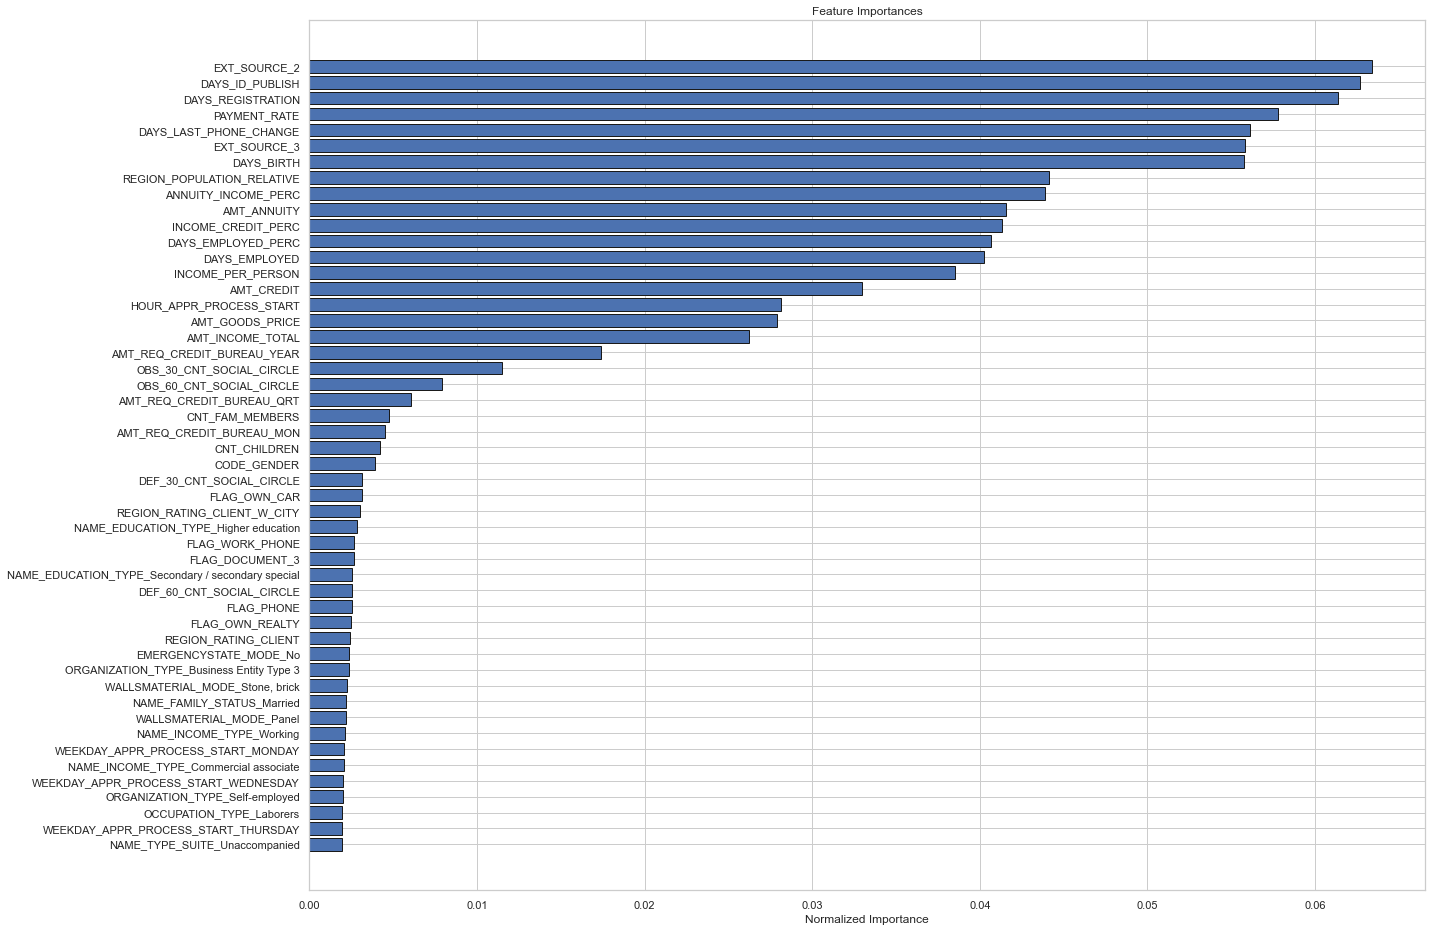

,index,feature,importance,importance_normalized
0,29,EXT_SOURCE_2,5770,0.063409
1,12,DAYS_ID_PUBLISH,5703,0.062673
2,11,DAYS_REGISTRATION,5587,0.061398
3,199,PAYMENT_RATE,5256,0.057761
4,35,DAYS_LAST_PHONE_CHANGE,5107,0.056123
...,...,...,...,...
195,38,FLAG_DOCUMENT_4,0,0.000000
196,88,NAME_FAMILY_STATUS_Unknown,0,0.000000
197,144,ORGANIZATION_TYPE_Industry: type 6,0,0.000000
198,51,FLAG_DOCUMENT_17,0,0.000000


In [172]:
# Affichage de l'importance des features/
plot_feature_importances(feature_importance_0)

In [173]:
features_selected_df = feature_importance_0.sort_values('importance', ascending=False).reset_index()
features_selected_df.head()

,index,feature,importance
0,29,EXT_SOURCE_2,5770
1,12,DAYS_ID_PUBLISH,5703
2,11,DAYS_REGISTRATION,5587
3,199,PAYMENT_RATE,5256
4,35,DAYS_LAST_PHONE_CHANGE,5107


In [174]:
# Select the 52 most important features 
relevant_features_df = features_selected_df.iloc[0:50:]

In [175]:
relevant_features_df['feature'].tolist()

['EXT_SOURCE_2',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'PAYMENT_RATE',
 'DAYS_LAST_PHONE_CHANGE',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'REGION_POPULATION_RELATIVE',
 'ANNUITY_INCOME_PERC',
 'AMT_ANNUITY',
 'INCOME_CREDIT_PERC',
 'DAYS_EMPLOYED_PERC',
 'DAYS_EMPLOYED',
 'INCOME_PER_PERSON',
 'AMT_CREDIT',
 'HOUR_APPR_PROCESS_START',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'CNT_FAM_MEMBERS',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'CNT_CHILDREN',
 'CODE_GENDER',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'FLAG_OWN_CAR',
 'REGION_RATING_CLIENT_W_CITY',
 'NAME_EDUCATION_TYPE_Higher education',
 'FLAG_WORK_PHONE',
 'FLAG_DOCUMENT_3',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_PHONE',
 'FLAG_OWN_REALTY',
 'REGION_RATING_CLIENT',
 'EMERGENCYSTATE_MODE_No',
 'ORGANIZATION_TYPE_Business Entity Type 3',
 'WALLSMATERIAL_MODE_Stone, brick',
 'NAME_FAMIL

In [176]:
#On créé un sous-échantillon de 50 features 
relevant_data_50 = data_train[['PAYMENT_RATE',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'DAYS_EMPLOYED',
 'AMT_CREDIT',
 'DAYS_LAST_PHONE_CHANGE',
 'CODE_GENDER',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED_PERC',
 'ANNUITY_INCOME_PERC',
 'INCOME_CREDIT_PERC',
 'NAME_EDUCATION_TYPE_Higher education',
 'FLAG_OWN_CAR',
 'REGION_POPULATION_RELATIVE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_INCOME_TOTAL',
 'NAME_FAMILY_STATUS_Married',
 'REGION_RATING_CLIENT_W_CITY',
 'INCOME_PER_PERSON',
 'FLAG_DOCUMENT_3',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'HOUR_APPR_PROCESS_START',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'FLAG_EMAIL',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_WORK_PHONE',
 'ORGANIZATION_TYPE_Self-employed',
 'WALLSMATERIAL_MODE_Panel',
 'NAME_INCOME_TYPE_Working',
 'OCCUPATION_TYPE_Core staff',
 'NAME_CONTRACT_TYPE_Cash loans',
 'OCCUPATION_TYPE_Drivers',
 'OCCUPATION_TYPE_Laborers',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'ORGANIZATION_TYPE_Transport: type 3',
 'ORGANIZATION_TYPE_Construction',
 'EMERGENCYSTATE_MODE_No',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'REGION_RATING_CLIENT',
 'CNT_FAM_MEMBERS',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_HOUSING_TYPE_Municipal apartment',
 'NAME_INCOME_TYPE_State servant',
 'TARGET']]

In [177]:
best_parameters_2, feature_importance_2, clf_2 = model_v1(LGBMClassifier(),
                                                          var_pipeline,
                                                          relevant_data_50,
                                                          eval_metric=Ind_bank)

100%|████████████████████████████████████████████████| 10/10 [16:35<00:00, 99.59s/trial, best loss: 0.1888041203830122]


In [178]:
# Affichage des meilleurs hyper-paramètres pour la métrique bancaire
best_parameters_2

{'colsample_by_tree': 0.7000000000000001,
 'learning_rate': 0.06548736147737465,
 'max_depth': 24.0,
 'n_estimators': 1200.0,
 'num_leaves': 84.0,
 'reg_alpha': 0.7000000000000001,
 'reg_lambda': 0.7000000000000001,
 'solvability_threshold': 0.47500000000000003,
 'subsample': 0.6000000000000001}

In [179]:
#Optimisation de la métrique ROC 
# Optimisation pour la métrique 'roc_auc'
best_parameters_3, feature_importance_3, clf_3 = model_v1(LGBMClassifier(),
                                                          var_pipeline,
                                                          relevant_data_50,
                                                          eval_metric=f1_score)

100%|███████████████████████████████████████████████| 10/10 [13:18<00:00, 79.88s/trial, best loss: 0.23766474846853547]


In [180]:
# Affichage des meilleurs hyper-paramètres
best_parameters_3

{'colsample_by_tree': 0.9,
 'learning_rate': 0.0398290456892464,
 'max_depth': 24.0,
 'n_estimators': 1600.0,
 'num_leaves': 84.0,
 'reg_alpha': 0.30000000000000004,
 'reg_lambda': 0.2,
 'solvability_threshold': 0.5750000000000001,
 'subsample': 1.0}

In [181]:
# On split le jeu d'entrainement en entrainement et test
train_set_50, valid_set_50 = train_test_split(relevant_data_50, test_size=0.2, random_state=42)

In [182]:
y_proba_2 = clf_2.predict_proba(relevant_data_50.drop(columns=["TARGET"]))[:, 1]
y_pred_2 = (y_proba_2 > best_parameters_2['solvability_threshold'])
y_pred_2 = np.array(y_pred_2 > 0) * 1

In [183]:
y_proba_3 = clf_3.predict_proba(relevant_data_50.drop(columns=["TARGET"]))[:, 1]
y_pred_3 = (y_proba_3 > best_parameters_3['solvability_threshold'])
y_pred_3 = np.array(y_pred_3 > 0) * 1

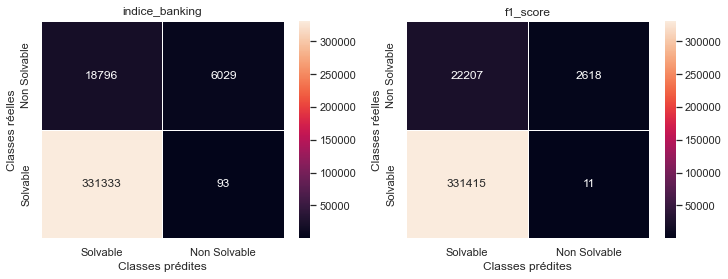

In [184]:
mat_conf_2 = plot_heatmap_confusion(relevant_data_50["TARGET"],
                       **{"indice_banking": y_pred_2, "f1_score": y_pred_3})

In [185]:
# Calcule du gain pour la métrique bancaire
J_2 = Ind_bank(relevant_data_50["TARGET"], y_pred_2)
# Calcul du gain pour la métrique métier
J_3 = Ind_bank(relevant_data_50["TARGET"], y_pred_3)
print("Le gain normalisé pour la métrique banking est de {:.2f} alors qu'il est de {:.2f} pour la métrique technique"
      .format(J_2, J_3))
print("La création de la métrique banking permet un gain de {:.1f}%".format(100*(J_2 - J_3)/J_2))

Le gain normalisé pour la métrique banking est de 0.79 alors qu'il est de 0.76 pour la métrique technique
La création de la métrique banking permet un gain de 4.7%


In [186]:
# Calcul les scores Accuracy, Recall et Roc_auc
scores_2 = calculate_multi_metrics(clf_2,
                                   relevant_data_50.drop(columns=["TARGET"]),
                                   relevant_data_50["TARGET"],
                                   best_parameters_2["solvability_threshold"],
                                   *[accuracy_score, recall_score, roc_auc_score])

In [187]:
# Calcul les scores Accuracy, Recall et Roc_auc
scores_3 = calculate_multi_metrics(clf_3,
                                   relevant_data_50.drop(columns=["TARGET"]),
                                   relevant_data_50["TARGET"],
                                   best_parameters_3["solvability_threshold"],
                                   *[accuracy_score, recall_score, roc_auc_score])

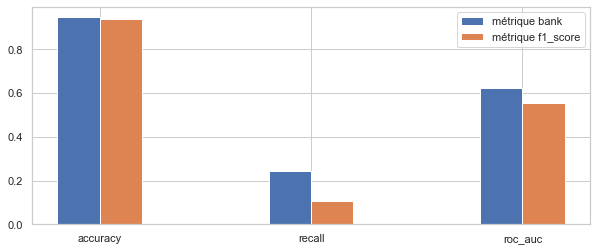

In [188]:
fig, ax = plt.subplots(1, figsize=(10, 4))

x = np.arange(3)  # the label locations
width = 0.2  # the width of the bars

ax.bar(x - width/2, scores_2, width, label='métrique bank')

ax.bar(x + width/2, scores_3, width, label='métrique f1_score')

ax.set_xticks(x)
ax.set_xticklabels(['accuracy', 'recall', 'roc_auc'])
ax.legend()
plt.show()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 23s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 31s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 16s
Installments payments df shape: (339587, 26)
Process installments payments - done in 28s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 17s
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797104	training's binary_logloss: 0.234829	valid_1's auc: 0.776089	valid_1's binary_logloss: 0.246759
[400]	training's auc: 0.819226	training's binary_logloss: 0.22537	valid_1's auc: 0.787159	valid_1's binary_logloss: 0.242511
[600]	training's auc: 0.834155	training's binary_logloss: 0.219277	valid_1's auc: 0.790742	valid_1's binary_logloss: 0.241208
[800]	training's auc: 0.846219	training's binary_logloss: 0.214311	valid_1's auc: 0.792638	valid_1's binary_logloss: 0.240572
[1000]	training's auc: 0.856646	training's binary_logloss: 0.20991	valid_1's auc: 0.793314	valid_1's binary_logloss: 0.240345
[1200]	training's auc: 0.866329	training's binary_logloss: 0.205763	valid_1's auc: 0.794016	valid_1's binary_logloss: 0.240111
[1400]	training's auc: 0.875268	training's binary_logloss: 0.2017	valid_1's auc: 0.794374	valid_1's binary_logloss: 0.240002
[1600]

C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796504	training's binary_logloss: 0.235573	valid_1's auc: 0.777058	valid_1's binary_logloss: 0.241702
[400]	training's auc: 0.819063	training's binary_logloss: 0.226043	valid_1's auc: 0.786754	valid_1's binary_logloss: 0.237454
[600]	training's auc: 0.833962	training's binary_logloss: 0.21997	valid_1's auc: 0.788941	valid_1's binary_logloss: 0.236447
[800]	training's auc: 0.846139	training's binary_logloss: 0.214955	valid_1's auc: 0.790289	valid_1's binary_logloss: 0.235906
[1000]	training's auc: 0.856195	training's binary_logloss: 0.210675	valid_1's auc: 0.790743	valid_1's binary_logloss: 0.235667
[1200]	training's auc: 0.865472	training's binary_logloss: 0.206638	valid_1's auc: 0.79094	valid_1's binary_logloss: 0.23555
[1400]	training's auc: 0.874355	training's binary_logloss: 0.202693	valid_1's auc: 0.791202	valid_1's binary_logloss: 0.235424
[1600

C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797097	training's binary_logloss: 0.235026	valid_1's auc: 0.76787	valid_1's binary_logloss: 0.246536
[400]	training's auc: 0.819952	training's binary_logloss: 0.225433	valid_1's auc: 0.778311	valid_1's binary_logloss: 0.242546
[600]	training's auc: 0.834998	training's binary_logloss: 0.219239	valid_1's auc: 0.781675	valid_1's binary_logloss: 0.241422
[800]	training's auc: 0.8474	training's binary_logloss: 0.214093	valid_1's auc: 0.783594	valid_1's binary_logloss: 0.240809
[1000]	training's auc: 0.857595	training's binary_logloss: 0.209775	valid_1's auc: 0.784536	valid_1's binary_logloss: 0.240494
[1200]	training's auc: 0.866985	training's binary_logloss: 0.205683	valid_1's auc: 0.785113	valid_1's binary_logloss: 0.240377
[1400]	training's auc: 0.875537	training's binary_logloss: 0.201832	valid_1's auc: 0.785241	valid_1's binary_logloss: 0.240407
Fold 

C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796781	training's binary_logloss: 0.23554	valid_1's auc: 0.778094	valid_1's binary_logloss: 0.241263
[400]	training's auc: 0.81928	training's binary_logloss: 0.225978	valid_1's auc: 0.788498	valid_1's binary_logloss: 0.236955
[600]	training's auc: 0.834386	training's binary_logloss: 0.219837	valid_1's auc: 0.792236	valid_1's binary_logloss: 0.235482
[800]	training's auc: 0.846366	training's binary_logloss: 0.214924	valid_1's auc: 0.793725	valid_1's binary_logloss: 0.23491
[1000]	training's auc: 0.857037	training's binary_logloss: 0.210442	valid_1's auc: 0.794901	valid_1's binary_logloss: 0.234455
[1200]	training's auc: 0.8665	training's binary_logloss: 0.206311	valid_1's auc: 0.795161	valid_1's binary_logloss: 0.234325
[1400]	training's auc: 0.875286	training's binary_logloss: 0.202334	valid_1's auc: 0.795642	valid_1's binary_logloss: 0.234145
[1600]	

C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796443	training's binary_logloss: 0.236317	valid_1's auc: 0.78032	valid_1's binary_logloss: 0.234124
[400]	training's auc: 0.819068	training's binary_logloss: 0.226741	valid_1's auc: 0.790482	valid_1's binary_logloss: 0.229854
[600]	training's auc: 0.833992	training's binary_logloss: 0.220619	valid_1's auc: 0.793639	valid_1's binary_logloss: 0.228569
[800]	training's auc: 0.846192	training's binary_logloss: 0.215603	valid_1's auc: 0.795317	valid_1's binary_logloss: 0.227936
[1000]	training's auc: 0.856531	training's binary_logloss: 0.211213	valid_1's auc: 0.796348	valid_1's binary_logloss: 0.22756
[1200]	training's auc: 0.866038	training's binary_logloss: 0.207091	valid_1's auc: 0.797078	valid_1's binary_logloss: 0.227334
[1400]	training's auc: 0.874456	training's binary_logloss: 0.203282	valid_1's auc: 0.797234	valid_1's binary_logloss: 0.227263
[160

C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797404	training's binary_logloss: 0.235337	valid_1's auc: 0.76717	valid_1's binary_logloss: 0.243343
[400]	training's auc: 0.820012	training's binary_logloss: 0.225758	valid_1's auc: 0.778167	valid_1's binary_logloss: 0.239452
[600]	training's auc: 0.835049	training's binary_logloss: 0.219617	valid_1's auc: 0.782224	valid_1's binary_logloss: 0.238116
[800]	training's auc: 0.847157	training's binary_logloss: 0.214639	valid_1's auc: 0.783885	valid_1's binary_logloss: 0.237496
[1000]	training's auc: 0.857708	training's binary_logloss: 0.210211	valid_1's auc: 0.784889	valid_1's binary_logloss: 0.237139
[1200]	training's auc: 0.867254	training's binary_logloss: 0.205959	valid_1's auc: 0.785179	valid_1's binary_logloss: 0.236995
[1400]	training's auc: 0.876057	training's binary_logloss: 0.201915	valid_1's auc: 0.785234	valid_1's binary_logloss: 0.236983
Fol

C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797268	training's binary_logloss: 0.235527	valid_1's auc: 0.774539	valid_1's binary_logloss: 0.240657
[400]	training's auc: 0.819627	training's binary_logloss: 0.225979	valid_1's auc: 0.784495	valid_1's binary_logloss: 0.236476
[600]	training's auc: 0.83472	training's binary_logloss: 0.219851	valid_1's auc: 0.787703	valid_1's binary_logloss: 0.235247
[800]	training's auc: 0.847018	training's binary_logloss: 0.21483	valid_1's auc: 0.78932	valid_1's binary_logloss: 0.234726
[1000]	training's auc: 0.85732	training's binary_logloss: 0.210487	valid_1's auc: 0.78994	valid_1's binary_logloss: 0.234503
[1200]	training's auc: 0.866926	training's binary_logloss: 0.206324	valid_1's auc: 0.790406	valid_1's binary_logloss: 0.234408
[1400]	training's auc: 0.875563	training's binary_logloss: 0.20244	valid_1's auc: 0.790384	valid_1's binary_logloss: 0.234439
Fold  7 

C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.797384	training's binary_logloss: 0.235077	valid_1's auc: 0.770478	valid_1's binary_logloss: 0.245343
[400]	training's auc: 0.819664	training's binary_logloss: 0.225542	valid_1's auc: 0.781776	valid_1's binary_logloss: 0.240982
[600]	training's auc: 0.834599	training's binary_logloss: 0.219451	valid_1's auc: 0.785968	valid_1's binary_logloss: 0.239525
[800]	training's auc: 0.846348	training's binary_logloss: 0.214629	valid_1's auc: 0.787951	valid_1's binary_logloss: 0.238904
[1000]	training's auc: 0.856847	training's binary_logloss: 0.210207	valid_1's auc: 0.788733	valid_1's binary_logloss: 0.238634
[1200]	training's auc: 0.866335	training's binary_logloss: 0.206035	valid_1's auc: 0.789318	valid_1's binary_logloss: 0.238496
[1400]	training's auc: 0.875156	training's binary_logloss: 0.202086	valid_1's auc: 0.789737	valid_1's binary_logloss: 0.238361
[1

C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796262	training's binary_logloss: 0.235491	valid_1's auc: 0.780614	valid_1's binary_logloss: 0.242519
[400]	training's auc: 0.819304	training's binary_logloss: 0.225829	valid_1's auc: 0.7906	valid_1's binary_logloss: 0.238067
[600]	training's auc: 0.834369	training's binary_logloss: 0.219696	valid_1's auc: 0.794411	valid_1's binary_logloss: 0.236568
[800]	training's auc: 0.846365	training's binary_logloss: 0.214734	valid_1's auc: 0.795589	valid_1's binary_logloss: 0.235997
[1000]	training's auc: 0.857347	training's binary_logloss: 0.21016	valid_1's auc: 0.795693	valid_1's binary_logloss: 0.235837
[1200]	training's auc: 0.866959	training's binary_logloss: 0.20599	valid_1's auc: 0.796198	valid_1's binary_logloss: 0.235632
[1400]	training's auc: 0.876094	training's binary_logloss: 0.201939	valid_1's auc: 0.796356	valid_1's binary_logloss: 0.235572
[1600]

C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\robin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.796896	training's binary_logloss: 0.235586	valid_1's auc: 0.771623	valid_1's binary_logloss: 0.240838
[400]	training's auc: 0.819574	training's binary_logloss: 0.226061	valid_1's auc: 0.782718	valid_1's binary_logloss: 0.236567
[600]	training's auc: 0.834468	training's binary_logloss: 0.21995	valid_1's auc: 0.786322	valid_1's binary_logloss: 0.235229
[800]	training's auc: 0.846691	training's binary_logloss: 0.214993	valid_1's auc: 0.788052	valid_1's binary_logloss: 0.234624
[1000]	training's auc: 0.857452	training's binary_logloss: 0.210465	valid_1's auc: 0.789127	valid_1's binary_logloss: 0.234272
[1200]	training's auc: 0.867238	training's binary_logloss: 0.206246	valid_1's auc: 0.789493	valid_1's binary_logloss: 0.23412
[1400]	training's auc: 0.876043	training's binary_logloss: 0.202265	valid_1's auc: 0.789718	valid_1's binary_logloss: 0.23401
[1600

C:\Users\robin\AppData\Local\Temp\ipykernel_10356\2677549221.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


Run LightGBM with kfold - done in 2547s
Full model run - done in 2666s


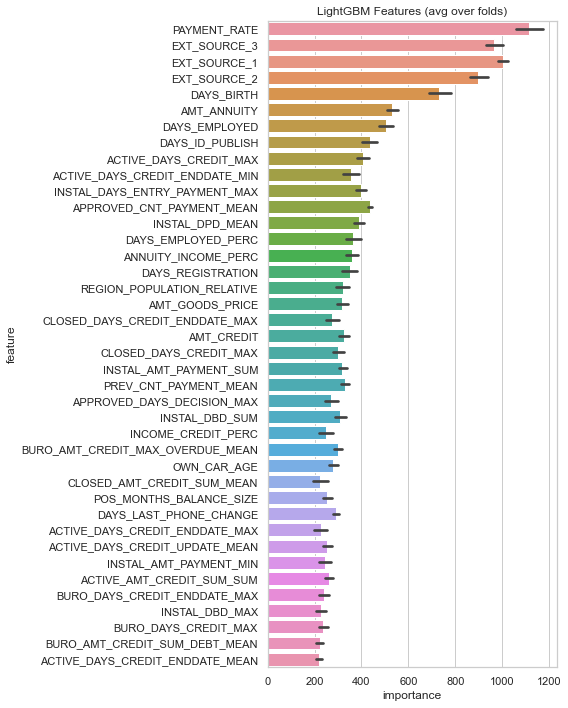

In [189]:
# Test with Kaggle kernel 
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx].to_numpy(), train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx].to_numpy(), train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        main()

In [195]:
#Préparation des données 

In [196]:
# Imputation of missing data by the median 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
relevant_data_50.iloc[:,:] = imputer.fit_transform(relevant_data_50)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [197]:
#Fit scaler to our training data
scaler = RobustScaler()
scaler.fit(relevant_data_50)
scaled_train = scaler.transform(relevant_data_50)

In [207]:
y_relevant_data_50 = relevant_data_50['TARGET']
y_relevant_data_50

SK_ID_CURR
100002.0    1.0
100003.0    0.0
100004.0    0.0
100006.0    0.0
100007.0    0.0
           ... 
456221.0    0.0
456222.0    0.0
456223.0    0.0
456224.0    0.0
456250.0    0.0
Name: TARGET, Length: 356251, dtype: float64

In [205]:
x_relevant_data_50 = relevant_data_50.drop(columns=["TARGET"])
x_relevant_data_50

,PAYMENT_RATE,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_ANNUITY,DAYS_EMPLOYED,AMT_CREDIT,DAYS_LAST_PHONE_CHANGE,...,OBS_30_CNT_SOCIAL_CIRCLE,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Construction,EMERGENCYSTATE_MODE_No,OBS_60_CNT_SOCIAL_CIRCLE,REGION_RATING_CLIENT,CNT_FAM_MEMBERS,NAME_EDUCATION_TYPE_Lower secondary,NAME_HOUSING_TYPE_Municipal apartment,NAME_INCOME_TYPE_State servant
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002.0,0.060749,0.139376,0.262949,-9461.0,-2120.0,351000.0,24700.5,-637.0,406597.5,-1134.0,...,2.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0
100003.0,0.027598,0.533482,0.622246,-16765.0,-291.0,1129500.0,35698.5,-1188.0,1293502.5,-828.0,...,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0
100004.0,0.050000,0.729567,0.555912,-19046.0,-2531.0,135000.0,6750.0,-225.0,135000.0,-815.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
100006.0,0.094941,0.533482,0.650442,-19005.0,-2437.0,297000.0,29686.5,-3039.0,312682.5,-617.0,...,2.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0
100007.0,0.042623,0.533482,0.322738,-19932.0,-3458.0,513000.0,21865.5,-3038.0,513000.0,-1106.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221.0,0.042354,0.643026,0.648575,-19970.0,-3399.0,270000.0,17473.5,-5169.0,412560.0,-684.0,...,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0
456222.0,0.051267,0.533482,0.684596,-11186.0,-3003.0,495000.0,31909.5,-1149.0,622413.0,0.0,...,2.0,0.0,0.0,0.0,2.0,2.0,4.0,0.0,0.0,0.0
456223.0,0.105414,0.283712,0.632770,-15922.0,-1504.0,315000.0,33205.5,-3037.0,315000.0,-838.0,...,0.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0


In [208]:
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(x_relevant_data_50.values, y_relevant_data_50.values, test_size=0.2, random_state=42)

In [209]:
# Increase the data to get a bigger proportion of positif targets
sm = SMOTE(random_state=42, sampling_strategy=0.2) # the ratio is chosen
# to correspond to the pareto law with the 80%/20% ratio
X_train_shap_sm, y_train_shap_sm = sm.fit_resample(X_train_shap, y_train_shap.ravel())  
    

In [217]:
lgbm_model_estimator = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

In [216]:
def model_trained (best_classifier, X, y):
    clf = best_classifier.fit(X,y)
    best_score = best_classifier.score(X,y)
    return clf,best_score    

In [218]:
lgbm_model,lgbm_score = model_trained (lgbm_model_estimator, X_train_shap_sm, y_train_shap_sm)

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


In [219]:
def prediction (clf,X,y):
    y_pred=clf.predict(X)
    y_prob = clf.predict_proba(X)
    print('Test set score: {:.4f}'.format(clf.score(X, y)))
    #auc_score = roc_auc_score(y, y_prob[:,1])
    #print('Test auc score :', auc_score)
    return y_pred,y_prob

In [220]:
# Prediction results for LGBM Classifier 
y_predicted_lgbmclf, y_probability_lgbmclf = prediction (lgbm_model,X_test_shap,y_test_shap)

Test set score: 0.9295


In [212]:
# Evaluation of the importance of features with shap 
import shap

In [213]:
def important_feature_df (classifier, X) :
    X_importance = X
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_importance)
    vals= np.abs(shap_values).mean(0)
    x = pd.DataFrame(X)
    feature_importance = pd.DataFrame(list(zip(x.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    return feature_importance

In [214]:
def feature_importance_graphic(classifier, X):
    X_importance = X
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_importance)
    shap.summary_plot(shap_values[1], X_importance)
    shap.summary_plot(shap_values, X_importance, plot_type='bar')
    #shap.force_plot(explainer.expected_value[1], shap_values[1], X)
    return 

In [221]:
#Features Importance avec LGBM et les meilleurs paramètres 
# make sure the SHAP values add up to marginal predictions
# pred = xgb_cl.predict(X_train_data_smt)
explainer_lgbm = shap.Explainer(lgbm_model)
shap_values_lgbm = explainer_lgbm.shap_values(X_train_shap_sm)
# shap_obj = explainer(X_train_data_smt)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [224]:
# Create a tree explainer
lgbm_explainer = shap.Explainer(
    lgbm_model, X_train_shap_sm, feature_names=relevant_data_50.columns.tolist()
)

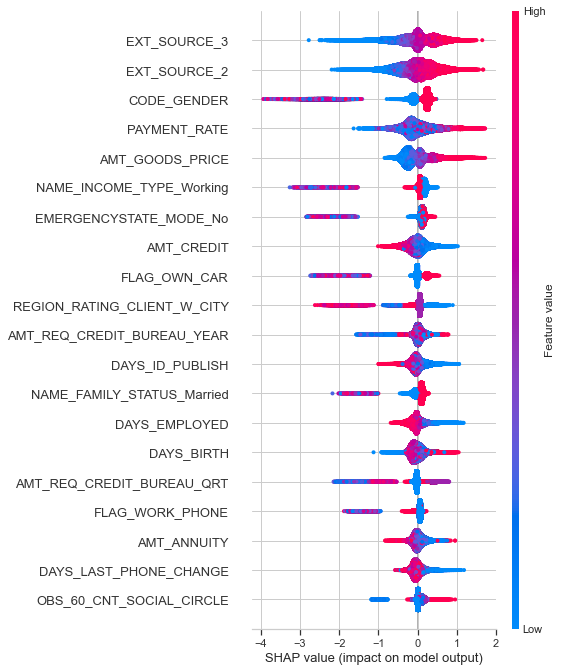

In [225]:
shap.summary_plot(shap_values_lgbm[0], X_train_shap_sm, feature_names=relevant_data_50.columns.tolist())

In [226]:
### Export data to dashbord
filename = 'classifier_lgbm_model_with_relevantdata50.pkl'
pickle.dump(lgbm_model, open(filename, 'wb'))

In [ ]:
#Brouillon

In [ ]:
data_export = relevant_data.merge(target, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')
data_export.head()

In [ ]:
data_export_complete = data_export.to_csv("dataset_exported_complete.csv",index=True)

In [ ]:
data_brut_export = train_new[train_new['SK_ID_CURR'].isin(train_new.SK_ID_CURR)]
data_brut_export.head()

In [ ]:
data_brut_export.set_index(['SK_ID_CURR'],inplace = True)

In [ ]:
data_brut_export.head()

In [ ]:
data_brut_export = data_brut_export.iloc[0:10000].copy()

In [ ]:
data_brut_export = data_brut_export.to_csv("dataset_exported_brut.csv",index=True)

In [ ]:
data_export = data_export.iloc[0:10000].copy()

In [ ]:
data_export.info()

In [ ]:
data_export.to_csv("dataset_exported_10000.csv",index=True)

In [ ]:
data_export.head()